# Configuration

In [3]:
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from data.preprocessing import load_raw_data, preprocess_datasets
from training.train import run_model_comparison
from training.summary import create_summary_table, generate_conclusions
from analysis.performance import plot_training_history, plot_performance_comparison
from analysis.bias import analyze_bias, plot_target_group_performance
from analysis.errors import analyze_errors
from analysis.efficiency import analyze_efficiency
from utils.helpers import set_seed, save_results
from visualization.plots import (
    plot_class_distribution, 
    plot_text_length_distribution, 
    plot_target_group_distribution_by_class
)
from analysis.bias import plot_gmb_metrics

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading english - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_1grams.txt


In [4]:
from config import (
    DATASET_PATH, BATCH_SIZE, EPOCHS, RANDOM_SEED, MODELS
)

# Set the random seed for reproducibility
set_seed(42)

# Load and Preprocess Data

In [5]:
# This will efficiently preprocess data only once
data_3class, data_2class = preprocess_datasets(DATASET_PATH)

print(f"3-class dataset shape: {data_3class.shape}")
print(f"2-class dataset shape: {data_2class.shape}")

Loading raw data...
Processing and preprocessing entries...


Processing entries: 100%|██████████| 20148/20148 [02:25<00:00, 138.75entry/s]


Initial data: 20148
Uncertain data: 919
Total processed entries: 19229
Creating 3-class dataset...
Creating 2-class dataset...
3-class dataset shape: (19229, 5)
2-class dataset shape: (19229, 5)


# EDA

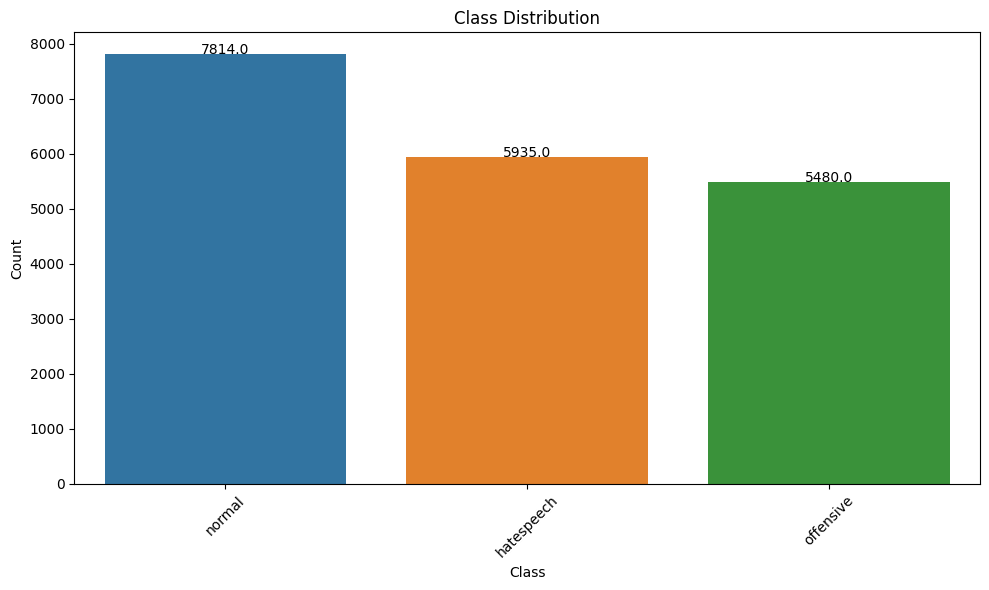

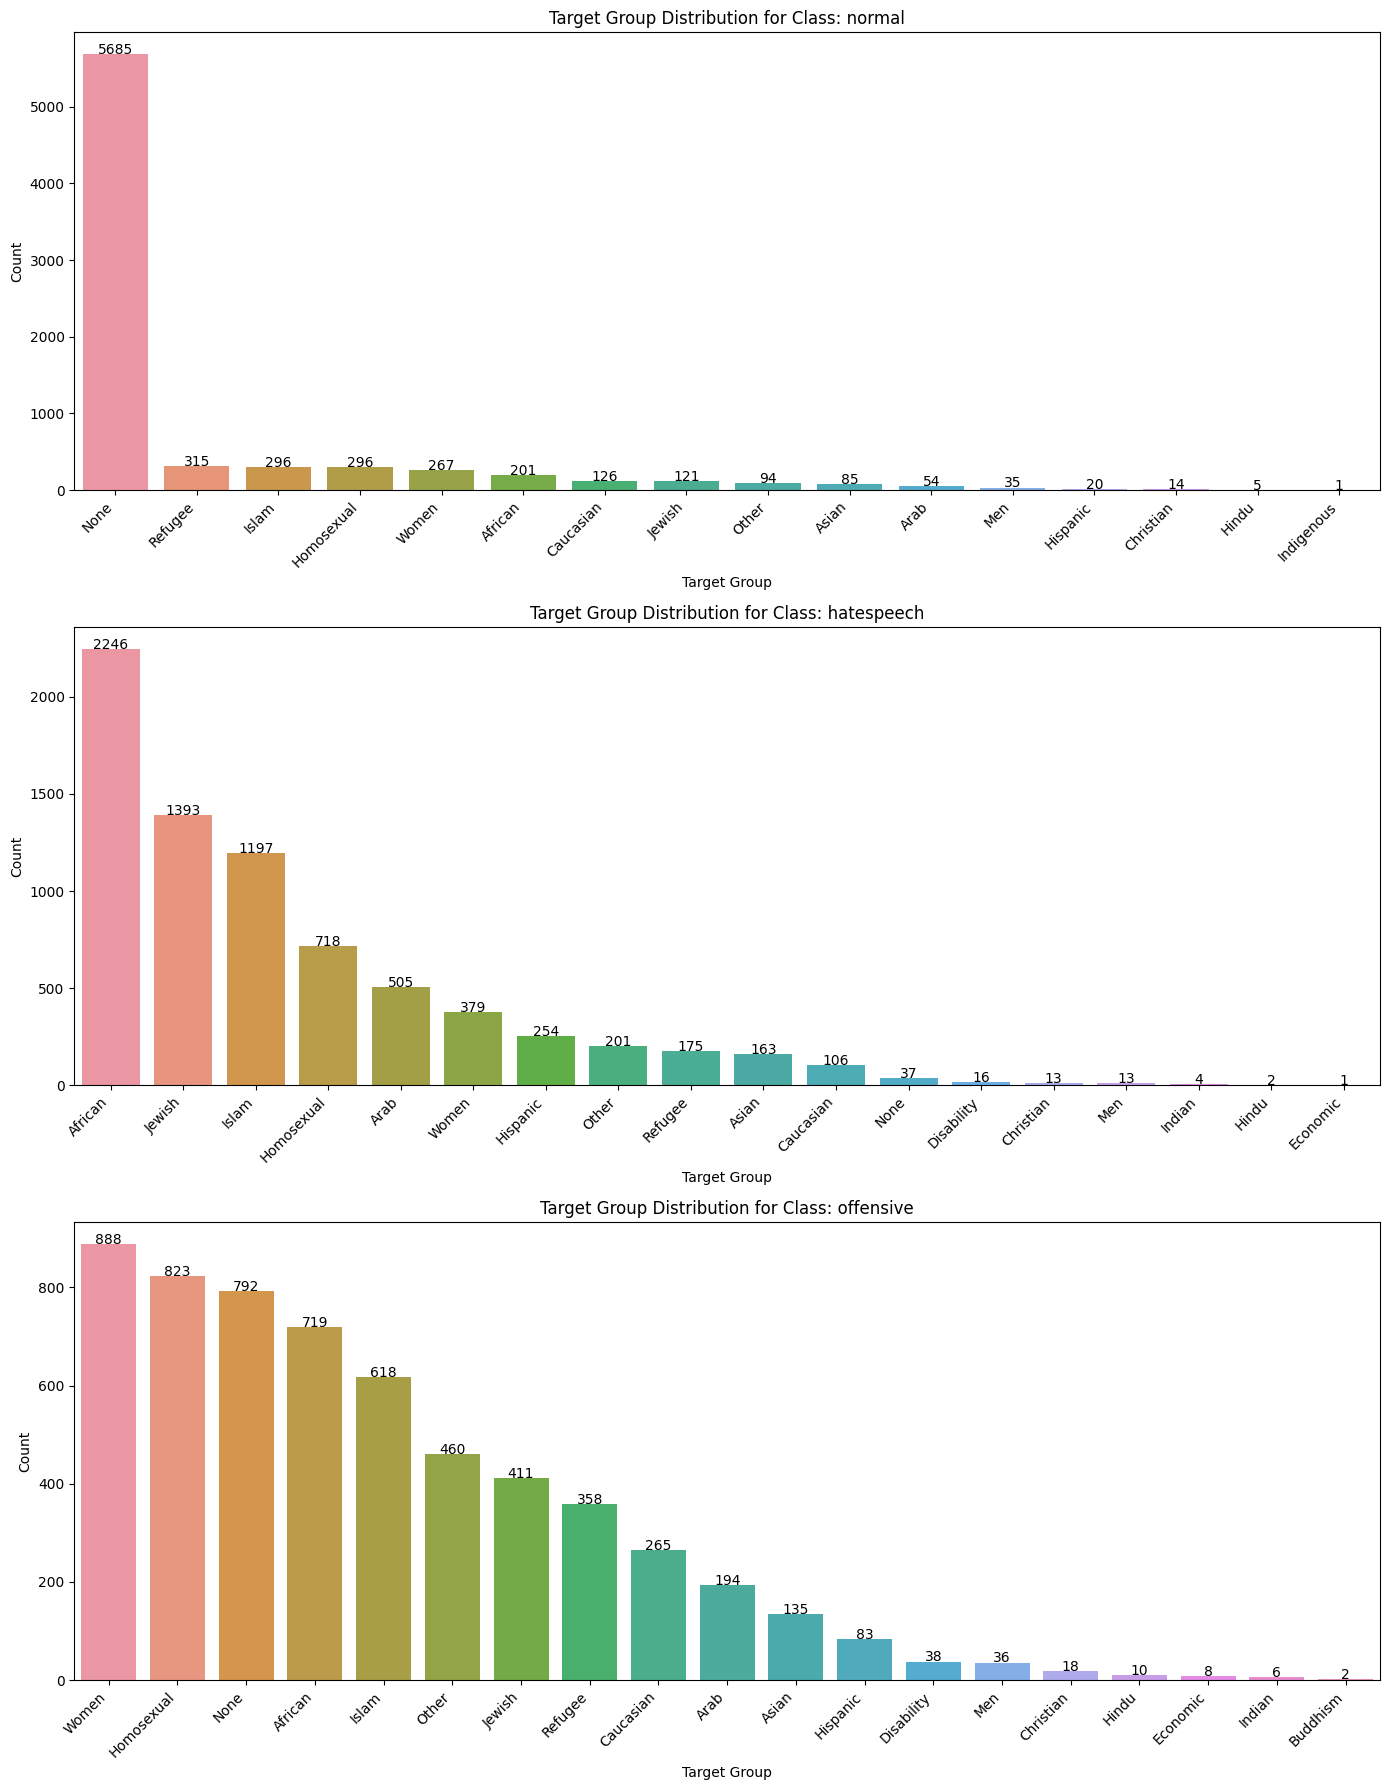

In [6]:
plot_class_distribution(data_3class)
plot_target_group_distribution_by_class(data_3class)

Target variable is not balanced, hence we modify the CrossEntropy loss function to account for the imbalance by using the class weights.

# Training

Running model comparison...

=== Running 3-Class Classification Models ===


Training bert-base-uncased for 3-class classification


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Train set: 15575, Validation set: 1731, Test set: 1923
Class weights: {1: 0.82029809869911, 0: 1.0800221898620068, 2: 1.169557708192536}
Using device: cuda


2025-05-02 03:33:05.796745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746156785.983487      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746156786.040914      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using custom classifier head for model: bert-base-uncased

Epoch 1/5


Training: 100%|██████████| 974/974 [03:27<00:00,  4.70batch/s, loss=0.746]


Average training loss: 0.8392


Evaluating: 100%|██████████| 109/109 [00:06<00:00, 16.72batch/s]


Validation loss: 0.7352
Validation accuracy: 0.6834
Validation F1 score: 0.6860
Validation val_loss improved from inf to 0.7352

Epoch 2/5


Training: 100%|██████████| 974/974 [03:27<00:00,  4.69batch/s, loss=0.31]


Average training loss: 0.6734


Evaluating: 100%|██████████| 109/109 [00:06<00:00, 16.72batch/s]


Validation loss: 0.6978
Validation accuracy: 0.7106
Validation F1 score: 0.7032
Validation val_loss improved from 0.7352 to 0.6978

Epoch 3/5


Training: 100%|██████████| 974/974 [03:27<00:00,  4.69batch/s, loss=1.34]


Average training loss: 0.5385


Evaluating: 100%|██████████| 109/109 [00:06<00:00, 16.65batch/s]


Validation loss: 0.7602
Validation accuracy: 0.6904
Validation F1 score: 0.6873
Validation val_loss did not improve. Best: 0.6978, Current: 0.7602
Early stopping counter: 1/2

Epoch 4/5


Training: 100%|██████████| 974/974 [03:27<00:00,  4.69batch/s, loss=0.325]


Average training loss: 0.4256


Evaluating: 100%|██████████| 109/109 [00:06<00:00, 16.71batch/s]


Validation loss: 0.8663
Validation accuracy: 0.6938
Validation F1 score: 0.6923
Validation val_loss did not improve. Best: 0.6978, Current: 0.8663
Early stopping counter: 2/2
Early stopping triggered. Best val_loss: 0.6978 at epoch 2
Loading best model from epoch 2


Evaluating: 100%|██████████| 121/121 [00:07<00:00, 16.55batch/s]



Test Results:
Loss: 0.7039
Accuracy: 0.6973
Macro F1 Score: 0.6887


Predicting: 100%|██████████| 121/121 [00:07<00:00, 16.65batch/s]


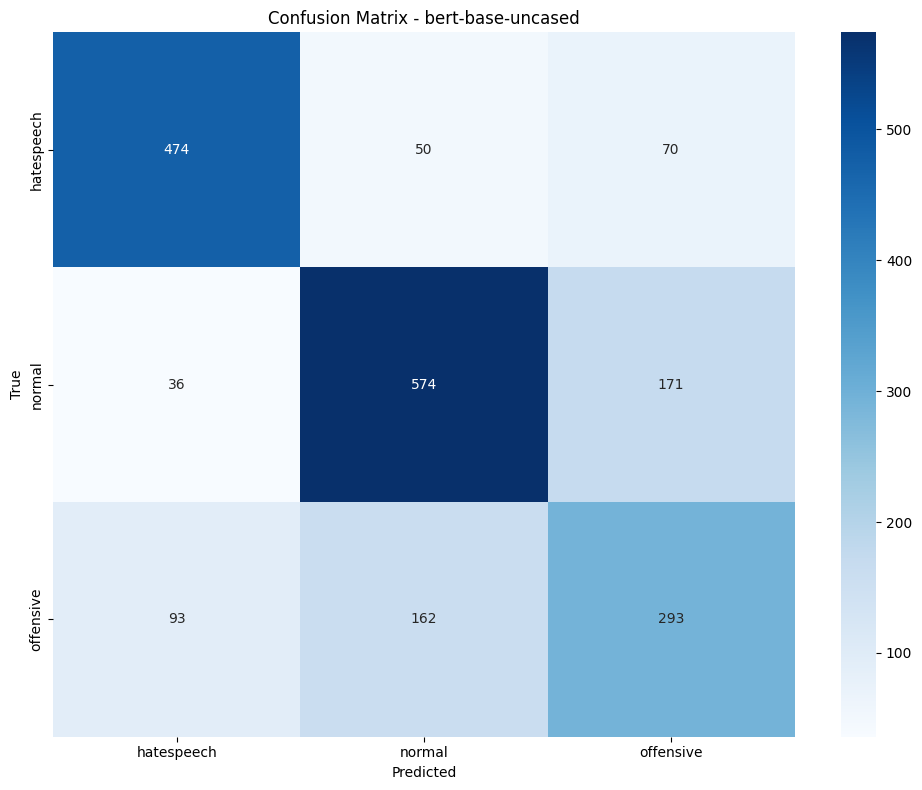

Model saved to saved_models/bert-base-uncased_3class

Bias AUC Metrics:
GMB-SUBGROUP-AUC: 0.4481
GMB-BPSN-AUC: 0.5415
GMB-BNSP-AUC: 0.3759
GMB-COMBINED-AUC: 0.4275

BNSP AUROC by Target Group:
African: AUROC = 0.5260
Islam: AUROC = 0.4099
Homosexual: AUROC = 0.3205
Jewish: AUROC = 0.5601
Women: AUROC = 0.4589
Refugee: AUROC = 0.2958
Arab: AUROC = 0.5514
Caucasian: AUROC = 0.4051
Asian: AUROC = 0.3222
Hispanic: AUROC = 0.5603

Training distilbert-base-uncased for 3-class classification


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Train set: 15575, Validation set: 1731, Test set: 1923
Class weights: {1: 0.82029809869911, 0: 1.0800221898620068, 2: 1.169557708192536}
Using device: cuda
No classifier dropout parameter found in config. Model: distilbert-base-uncased
Please use custom classifier head if you want to implement for this model


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using custom classifier head for model: distilbert-base-uncased

Epoch 1/5


Training: 100%|██████████| 974/974 [01:49<00:00,  8.91batch/s, loss=0.505]


Average training loss: 0.8192


Evaluating: 100%|██████████| 109/109 [00:03<00:00, 31.03batch/s]


Validation loss: 0.7152
Validation accuracy: 0.7008
Validation F1 score: 0.6858
Validation val_loss improved from inf to 0.7152

Epoch 2/5


Training: 100%|██████████| 974/974 [01:49<00:00,  8.91batch/s, loss=1.17]


Average training loss: 0.6626


Evaluating: 100%|██████████| 109/109 [00:03<00:00, 31.03batch/s]


Validation loss: 0.7093
Validation accuracy: 0.7008
Validation F1 score: 0.6981
Validation val_loss improved from 0.7152 to 0.7093

Epoch 3/5


Training: 100%|██████████| 974/974 [01:49<00:00,  8.91batch/s, loss=0.213]


Average training loss: 0.5404


Evaluating: 100%|██████████| 109/109 [00:03<00:00, 31.09batch/s]


Validation loss: 0.7632
Validation accuracy: 0.6742
Validation F1 score: 0.6755
Validation val_loss did not improve. Best: 0.7093, Current: 0.7632
Early stopping counter: 1/2

Epoch 4/5


Training: 100%|██████████| 974/974 [01:49<00:00,  8.91batch/s, loss=0.216]


Average training loss: 0.4252


Evaluating: 100%|██████████| 109/109 [00:03<00:00, 30.40batch/s]


Validation loss: 0.8208
Validation accuracy: 0.6892
Validation F1 score: 0.6859
Validation val_loss did not improve. Best: 0.7093, Current: 0.8208
Early stopping counter: 2/2
Early stopping triggered. Best val_loss: 0.7093 at epoch 2
Loading best model from epoch 2


Evaluating: 100%|██████████| 121/121 [00:03<00:00, 30.81batch/s]



Test Results:
Loss: 0.7132
Accuracy: 0.6911
Macro F1 Score: 0.6875


Predicting: 100%|██████████| 121/121 [00:03<00:00, 30.88batch/s]


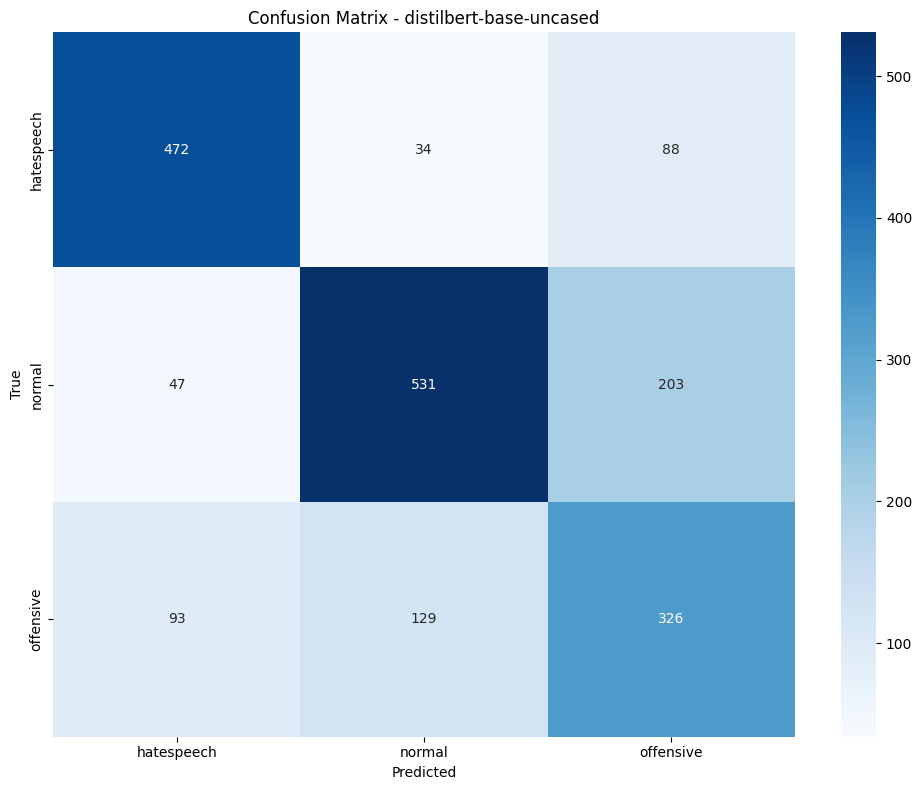

Model saved to saved_models/distilbert-base-uncased_3class

Bias AUC Metrics:
GMB-SUBGROUP-AUC: 0.5152
GMB-BPSN-AUC: 0.6453
GMB-BNSP-AUC: 0.4274
GMB-COMBINED-AUC: 0.4896

BNSP AUROC by Target Group:
African: AUROC = 0.6172
Islam: AUROC = 0.4969
Homosexual: AUROC = 0.3608
Jewish: AUROC = 0.6777
Women: AUROC = 0.4931
Refugee: AUROC = 0.3215
Arab: AUROC = 0.5965
Caucasian: AUROC = 0.4675
Asian: AUROC = 0.4000
Hispanic: AUROC = 0.7113

Training roberta-base for 3-class classification


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Train set: 15575, Validation set: 1731, Test set: 1923
Class weights: {1: 0.82029809869911, 0: 1.0800221898620068, 2: 1.169557708192536}
Using device: cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using custom classifier head for model: roberta-base

Epoch 1/5


Training: 100%|██████████| 974/974 [03:30<00:00,  4.64batch/s, loss=0.501]


Average training loss: 0.8357


Evaluating: 100%|██████████| 109/109 [00:06<00:00, 16.84batch/s]


Validation loss: 0.7318
Validation accuracy: 0.6938
Validation F1 score: 0.6781
Validation val_loss improved from inf to 0.7318

Epoch 2/5


Training: 100%|██████████| 974/974 [03:29<00:00,  4.64batch/s, loss=1.43]


Average training loss: 0.7091


Evaluating: 100%|██████████| 109/109 [00:06<00:00, 16.86batch/s]


Validation loss: 0.7303
Validation accuracy: 0.6979
Validation F1 score: 0.6781
Validation val_loss improved from 0.7318 to 0.7303

Epoch 3/5


Training: 100%|██████████| 974/974 [03:29<00:00,  4.64batch/s, loss=0.488]


Average training loss: 0.6176


Evaluating: 100%|██████████| 109/109 [00:06<00:00, 16.88batch/s]


Validation loss: 0.7788
Validation accuracy: 0.6719
Validation F1 score: 0.6682
Validation val_loss did not improve. Best: 0.7303, Current: 0.7788
Early stopping counter: 1/2

Epoch 4/5


Training: 100%|██████████| 974/974 [03:29<00:00,  4.64batch/s, loss=0.814]


Average training loss: 0.5377


Evaluating: 100%|██████████| 109/109 [00:06<00:00, 16.95batch/s]


Validation loss: 0.7730
Validation accuracy: 0.7094
Validation F1 score: 0.6974
Validation val_loss did not improve. Best: 0.7303, Current: 0.7730
Early stopping counter: 2/2
Early stopping triggered. Best val_loss: 0.7303 at epoch 2
Loading best model from epoch 2


Evaluating: 100%|██████████| 121/121 [00:07<00:00, 16.79batch/s]



Test Results:
Loss: 0.7389
Accuracy: 0.6927
Macro F1 Score: 0.6733


Predicting: 100%|██████████| 121/121 [00:07<00:00, 16.82batch/s]


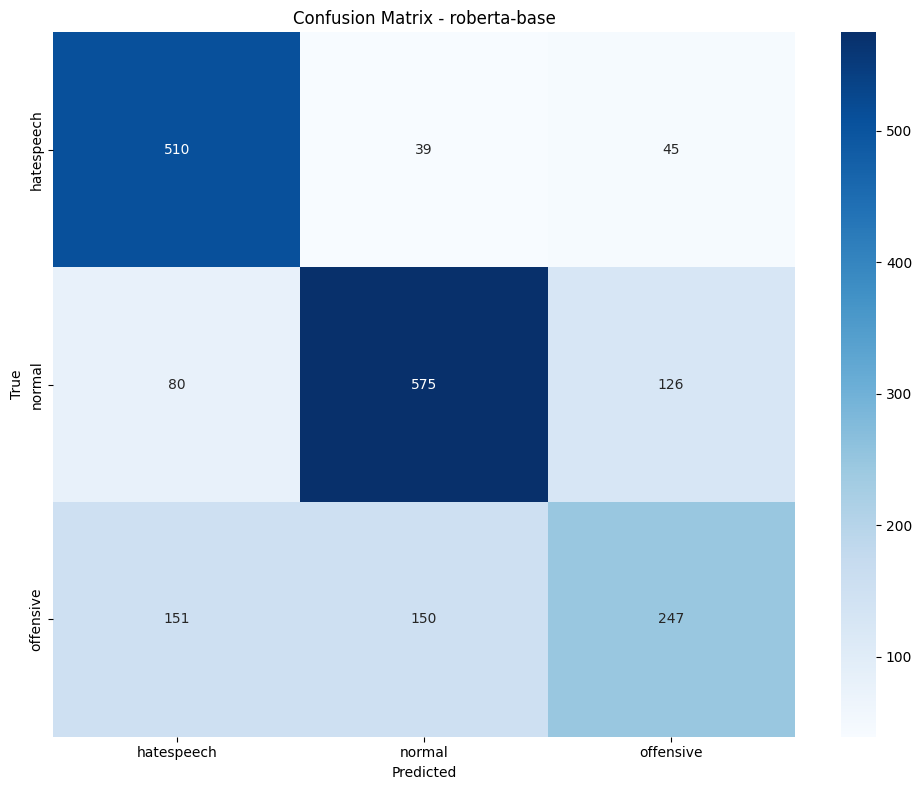

Model saved to saved_models/roberta-base_3class

Bias AUC Metrics:
GMB-SUBGROUP-AUC: 0.3848
GMB-BPSN-AUC: 0.5634
GMB-BNSP-AUC: 0.3716
GMB-COMBINED-AUC: 0.4045

BNSP AUROC by Target Group:
African: AUROC = 0.5741
Islam: AUROC = 0.4380
Homosexual: AUROC = 0.3644
Jewish: AUROC = 0.5762
Women: AUROC = 0.4363
Refugee: AUROC = 0.2680
Arab: AUROC = 0.5567
Caucasian: AUROC = 0.4046
Asian: AUROC = 0.3325
Hispanic: AUROC = 0.5596

Training xlnet-base-cased for 3-class classification


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Train set: 15575, Validation set: 1731, Test set: 1923
Class weights: {1: 0.82029809869911, 0: 1.0800221898620068, 2: 1.169557708192536}
Using device: cuda
No classifier dropout parameter found in config. Model: xlnet-base-cased
Please use custom classifier head if you want to implement for this model


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using custom classifier head for model: xlnet-base-cased

Epoch 1/5


Training:   0%|          | 3/974 [00:00<04:31,  3.58batch/s, loss=1.13]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

Training: 100%|██████████| 974/974 [04:12<00:00,  3.85batch/s, loss=0.701]


Average training loss: 0.8654


Evaluating: 100%|██████████| 109/109 [00:09<00:00, 11.08batch/s]


Validation loss: 0.7657
Validation accuracy: 0.6932
Validation F1 score: 0.6831
Validation val_loss improved from inf to 0.7657

Epoch 2/5


Training: 100%|██████████| 974/974 [04:12<00:00,  3.86batch/s, loss=0.576]


Average training loss: 0.7092


Evaluating: 100%|██████████| 109/109 [00:09<00:00, 11.05batch/s]


Validation loss: 0.7059
Validation accuracy: 0.6938
Validation F1 score: 0.6902
Validation val_loss improved from 0.7657 to 0.7059

Epoch 3/5


Training: 100%|██████████| 974/974 [04:12<00:00,  3.86batch/s, loss=1.15]


Average training loss: 0.5976


Evaluating: 100%|██████████| 109/109 [00:09<00:00, 11.08batch/s]


Validation loss: 0.7360
Validation accuracy: 0.7036
Validation F1 score: 0.6955
Validation val_loss did not improve. Best: 0.7059, Current: 0.7360
Early stopping counter: 1/2

Epoch 4/5


Training: 100%|██████████| 974/974 [04:12<00:00,  3.85batch/s, loss=0.355]


Average training loss: 0.4904


Evaluating: 100%|██████████| 109/109 [00:09<00:00, 11.04batch/s]


Validation loss: 0.8025
Validation accuracy: 0.6932
Validation F1 score: 0.6872
Validation val_loss did not improve. Best: 0.7059, Current: 0.8025
Early stopping counter: 2/2
Early stopping triggered. Best val_loss: 0.7059 at epoch 2
Loading best model from epoch 2


Evaluating: 100%|██████████| 121/121 [00:10<00:00, 11.00batch/s]



Test Results:
Loss: 0.7169
Accuracy: 0.6875
Macro F1 Score: 0.6834


Predicting: 100%|██████████| 121/121 [00:11<00:00, 10.93batch/s]


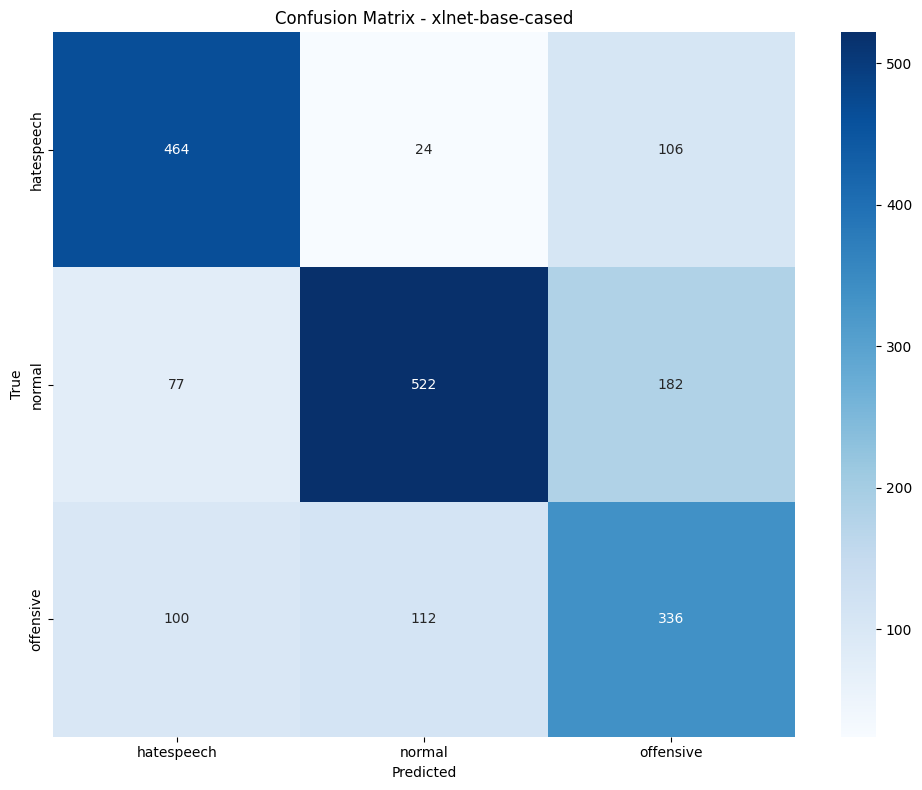

Model saved to saved_models/xlnet-base-cased_3class

Bias AUC Metrics:
GMB-SUBGROUP-AUC: 0.5262
GMB-BPSN-AUC: 0.6703
GMB-BNSP-AUC: 0.4583
GMB-COMBINED-AUC: 0.5165

BNSP AUROC by Target Group:
African: AUROC = 0.7191
Islam: AUROC = 0.5196
Homosexual: AUROC = 0.4322
Jewish: AUROC = 0.7345
Women: AUROC = 0.5193
Refugee: AUROC = 0.3389
Arab: AUROC = 0.6634
Caucasian: AUROC = 0.4186
Asian: AUROC = 0.4579
Hispanic: AUROC = 0.6936

Training microsoft/deberta-v3-base for 3-class classification


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Train set: 15575, Validation set: 1731, Test set: 1923
Class weights: {1: 0.82029809869911, 0: 1.0800221898620068, 2: 1.169557708192536}
Using device: cuda
No classifier dropout parameter found in config. Model: microsoft/deberta-v3-base
Please use custom classifier head if you want to implement for this model


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using custom classifier head for model: microsoft/deberta-v3-base

Epoch 1/5


Training:   0%|          | 0/974 [00:00<?, ?batch/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Training: 100%|██████████| 974/974 [04:26<00:00,  3.66batch/s, loss=0.427]


Average training loss: 0.8335


Evaluating: 100%|██████████| 109/109 [00:08<00:00, 12.36batch/s]


Validation loss: 0.7208
Validation accuracy: 0.6932
Validation F1 score: 0.6873
Validation val_loss improved from inf to 0.7208

Epoch 2/5


Training: 100%|██████████| 974/974 [04:25<00:00,  3.67batch/s, loss=0.763]


Average training loss: 0.6865


Evaluating: 100%|██████████| 109/109 [00:08<00:00, 12.38batch/s]


Validation loss: 0.7076
Validation accuracy: 0.7036
Validation F1 score: 0.6938
Validation val_loss improved from 0.7208 to 0.7076

Epoch 3/5


Training: 100%|██████████| 974/974 [04:25<00:00,  3.67batch/s, loss=0.348]


Average training loss: 0.5915


Evaluating: 100%|██████████| 109/109 [00:08<00:00, 12.36batch/s]


Validation loss: 0.7283
Validation accuracy: 0.6973
Validation F1 score: 0.6877
Validation val_loss did not improve. Best: 0.7076, Current: 0.7283
Early stopping counter: 1/2

Epoch 4/5


Training: 100%|██████████| 974/974 [04:25<00:00,  3.67batch/s, loss=0.615]


Average training loss: 0.4992


Evaluating: 100%|██████████| 109/109 [00:08<00:00, 12.35batch/s]


Validation loss: 0.7731
Validation accuracy: 0.7008
Validation F1 score: 0.6919
Validation val_loss did not improve. Best: 0.7076, Current: 0.7731
Early stopping counter: 2/2
Early stopping triggered. Best val_loss: 0.7076 at epoch 2
Loading best model from epoch 2


Evaluating: 100%|██████████| 121/121 [00:09<00:00, 12.31batch/s]



Test Results:
Loss: 0.6869
Accuracy: 0.7155
Macro F1 Score: 0.7033


Predicting: 100%|██████████| 121/121 [00:09<00:00, 12.39batch/s]


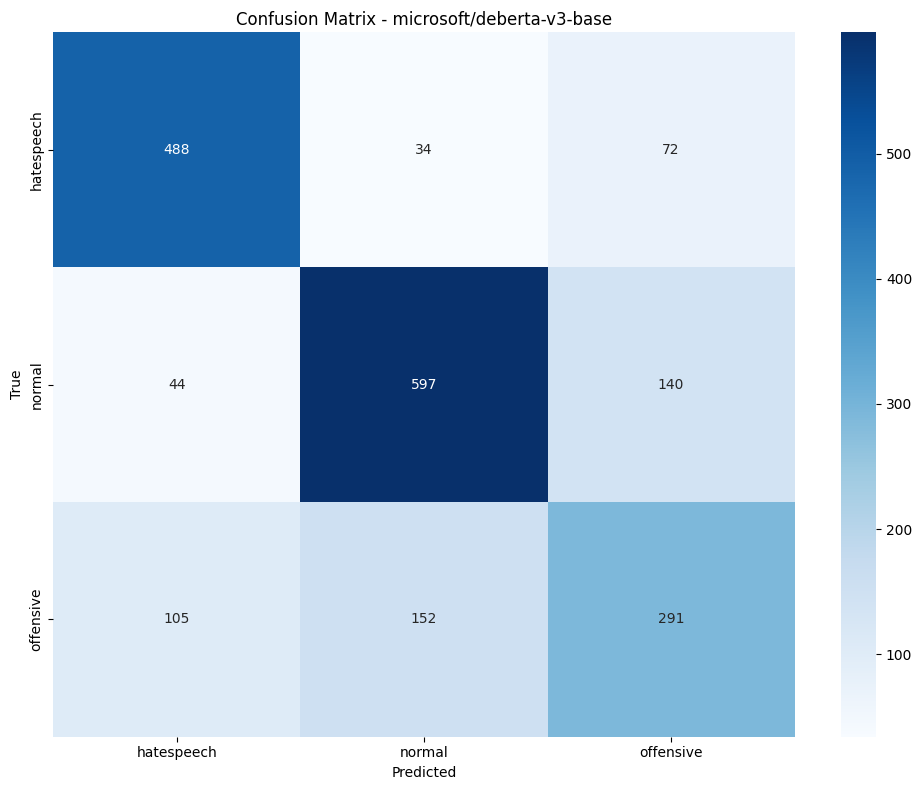

Model saved to saved_models/microsoft_deberta-v3-base_3class

Bias AUC Metrics:
GMB-SUBGROUP-AUC: 0.4498
GMB-BPSN-AUC: 0.6110
GMB-BNSP-AUC: 0.3521
GMB-COMBINED-AUC: 0.4126

BNSP AUROC by Target Group:
African: AUROC = 0.6366
Islam: AUROC = 0.4663
Homosexual: AUROC = 0.4107
Jewish: AUROC = 0.6517
Women: AUROC = 0.4688
Refugee: AUROC = 0.2422
Arab: AUROC = 0.6323
Caucasian: AUROC = 0.3716
Asian: AUROC = 0.3209
Hispanic: AUROC = 0.6216

=== Running Binary Classification Models ===


Training bert-base-uncased for binary classification
Train set: 15575, Validation set: 1731, Test set: 1923
Class weights: {1: 0.8423472147106544, 0: 1.2302527646129542}
Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using custom classifier head for model: bert-base-uncased

Epoch 1/5


Training: 100%|██████████| 974/974 [03:27<00:00,  4.69batch/s, loss=0.147]


Average training loss: 0.5213


Evaluating: 100%|██████████| 109/109 [00:06<00:00, 16.70batch/s]


Validation loss: 0.4742
Validation accuracy: 0.7799
Validation F1 score: 0.7614
Validation val_loss improved from inf to 0.4742

Epoch 2/5


Training: 100%|██████████| 974/974 [03:27<00:00,  4.69batch/s, loss=0.375]


Average training loss: 0.3983


Evaluating: 100%|██████████| 109/109 [00:06<00:00, 16.75batch/s]


Validation loss: 0.4368
Validation accuracy: 0.7886
Validation F1 score: 0.7794
Validation val_loss improved from 0.4742 to 0.4368

Epoch 3/5


Training: 100%|██████████| 974/974 [03:27<00:00,  4.69batch/s, loss=1.27]


Average training loss: 0.2958


Evaluating: 100%|██████████| 109/109 [00:06<00:00, 16.65batch/s]


Validation loss: 0.5218
Validation accuracy: 0.7857
Validation F1 score: 0.7776
Validation val_loss did not improve. Best: 0.4368, Current: 0.5218
Early stopping counter: 1/2

Epoch 4/5


Training: 100%|██████████| 974/974 [03:27<00:00,  4.69batch/s, loss=0.277]


Average training loss: 0.2138


Evaluating: 100%|██████████| 109/109 [00:06<00:00, 16.70batch/s]


Validation loss: 0.7272
Validation accuracy: 0.7834
Validation F1 score: 0.7775
Validation val_loss did not improve. Best: 0.4368, Current: 0.7272
Early stopping counter: 2/2
Early stopping triggered. Best val_loss: 0.4368 at epoch 2
Loading best model from epoch 2


Evaluating: 100%|██████████| 121/121 [00:07<00:00, 16.46batch/s]



Test Results:
Loss: 0.4291
Accuracy: 0.7941
Macro F1 Score: 0.7865


Predicting: 100%|██████████| 121/121 [00:07<00:00, 16.69batch/s]


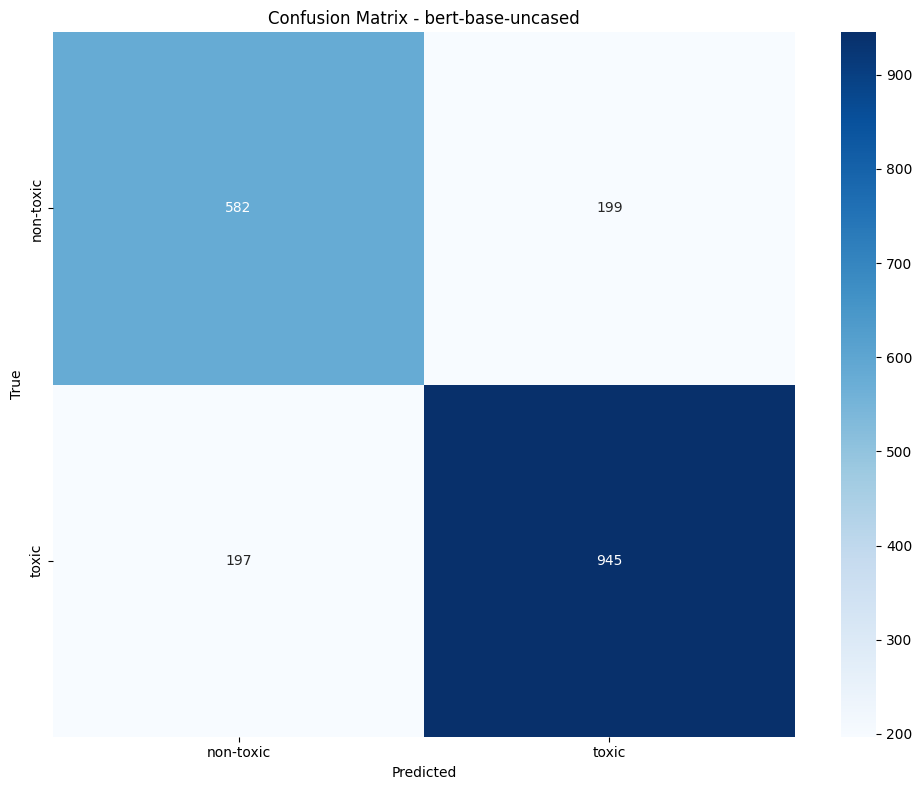

Model saved to saved_models/bert-base-uncased_binary

Bias AUC Metrics:
GMB-SUBGROUP-AUC: 0.8249
GMB-BPSN-AUC: 0.8034
GMB-BNSP-AUC: 0.8486
GMB-COMBINED-AUC: 0.8244

BNSP AUROC by Target Group:
African: AUROC = 0.9337
Islam: AUROC = 0.9155
Jewish: AUROC = 0.9522
Homosexual: AUROC = 0.8879
Women: AUROC = 0.8574
Refugee: AUROC = 0.7449
Arab: AUROC = 0.9194
Caucasian: AUROC = 0.7611
Hispanic: AUROC = 0.9672
Asian: AUROC = 0.7768

Training distilbert-base-uncased for binary classification
Train set: 15575, Validation set: 1731, Test set: 1923
Class weights: {1: 0.8423472147106544, 0: 1.2302527646129542}
Using device: cuda
No classifier dropout parameter found in config. Model: distilbert-base-uncased
Please use custom classifier head if you want to implement for this model


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using custom classifier head for model: distilbert-base-uncased

Epoch 1/5


Training: 100%|██████████| 974/974 [01:49<00:00,  8.89batch/s, loss=0.641]


Average training loss: 0.5176


Evaluating: 100%|██████████| 109/109 [00:03<00:00, 30.60batch/s]


Validation loss: 0.4413
Validation accuracy: 0.7972
Validation F1 score: 0.7945
Validation val_loss improved from inf to 0.4413

Epoch 2/5


Training: 100%|██████████| 974/974 [01:49<00:00,  8.90batch/s, loss=0.267]


Average training loss: 0.3967


Evaluating: 100%|██████████| 109/109 [00:03<00:00, 30.85batch/s]


Validation loss: 0.4446
Validation accuracy: 0.7995
Validation F1 score: 0.7951
Validation val_loss did not improve. Best: 0.4413, Current: 0.4446
Early stopping counter: 1/2

Epoch 3/5


Training: 100%|██████████| 974/974 [01:49<00:00,  8.90batch/s, loss=0.0985]


Average training loss: 0.3001


Evaluating: 100%|██████████| 109/109 [00:03<00:00, 30.81batch/s]


Validation loss: 0.5180
Validation accuracy: 0.7955
Validation F1 score: 0.7859
Validation val_loss did not improve. Best: 0.4413, Current: 0.5180
Early stopping counter: 2/2
Early stopping triggered. Best val_loss: 0.4413 at epoch 1
Loading best model from epoch 1


Evaluating: 100%|██████████| 121/121 [00:03<00:00, 30.69batch/s]



Test Results:
Loss: 0.4585
Accuracy: 0.7764
Macro F1 Score: 0.7732


Predicting: 100%|██████████| 121/121 [00:03<00:00, 30.86batch/s]


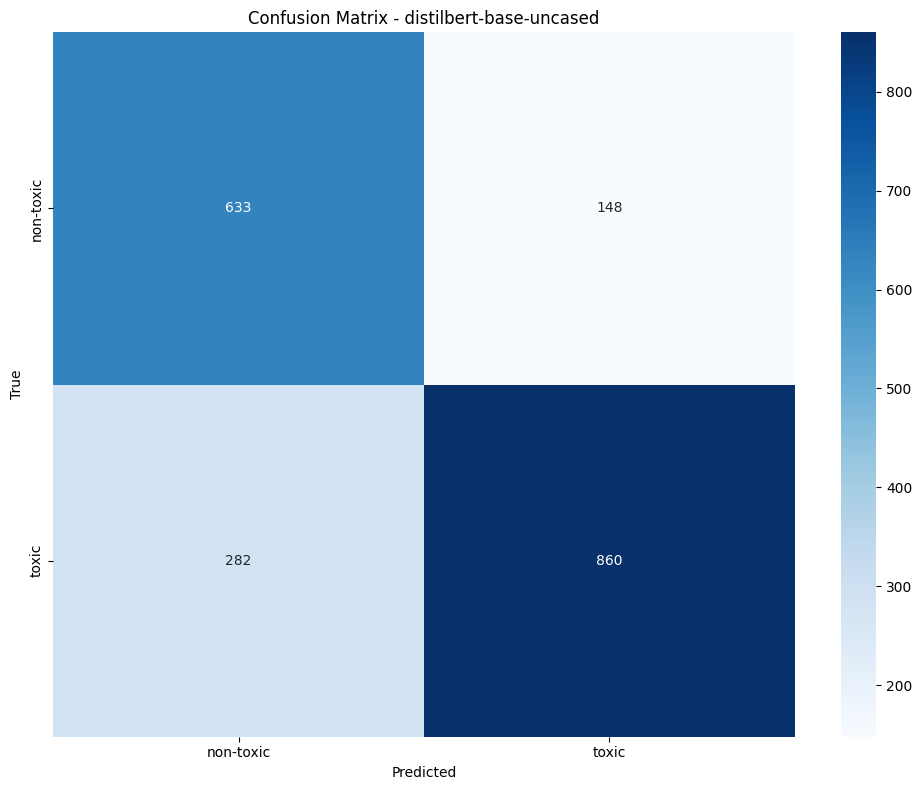

Model saved to saved_models/distilbert-base-uncased_binary

Bias AUC Metrics:
GMB-SUBGROUP-AUC: 0.8063
GMB-BPSN-AUC: 0.7469
GMB-BNSP-AUC: 0.8142
GMB-COMBINED-AUC: 0.7855

BNSP AUROC by Target Group:
African: AUROC = 0.9240
Islam: AUROC = 0.9074
Jewish: AUROC = 0.9551
Homosexual: AUROC = 0.8526
Women: AUROC = 0.8129
Refugee: AUROC = 0.7600
Arab: AUROC = 0.9191
Caucasian: AUROC = 0.6502
Hispanic: AUROC = 0.9601
Asian: AUROC = 0.7904

Training roberta-base for binary classification
Train set: 15575, Validation set: 1731, Test set: 1923
Class weights: {1: 0.8423472147106544, 0: 1.2302527646129542}
Using device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using custom classifier head for model: roberta-base

Epoch 1/5


Training: 100%|██████████| 974/974 [03:30<00:00,  4.63batch/s, loss=0.762]


Average training loss: 0.5291


Evaluating: 100%|██████████| 109/109 [00:06<00:00, 16.83batch/s]


Validation loss: 0.4710
Validation accuracy: 0.7828
Validation F1 score: 0.7746
Validation val_loss improved from inf to 0.4710

Epoch 2/5


Training: 100%|██████████| 974/974 [03:30<00:00,  4.64batch/s, loss=0.628]


Average training loss: 0.4335


Evaluating: 100%|██████████| 109/109 [00:06<00:00, 16.89batch/s]


Validation loss: 0.4366
Validation accuracy: 0.7955
Validation F1 score: 0.7931
Validation val_loss improved from 0.4710 to 0.4366

Epoch 3/5


Training: 100%|██████████| 974/974 [03:30<00:00,  4.64batch/s, loss=0.183]


Average training loss: 0.3674


Evaluating: 100%|██████████| 109/109 [00:06<00:00, 16.75batch/s]


Validation loss: 0.5106
Validation accuracy: 0.7891
Validation F1 score: 0.7861
Validation val_loss did not improve. Best: 0.4366, Current: 0.5106
Early stopping counter: 1/2

Epoch 4/5


Training: 100%|██████████| 974/974 [03:29<00:00,  4.64batch/s, loss=0.156]


Average training loss: 0.3041


Evaluating: 100%|██████████| 109/109 [00:06<00:00, 16.82batch/s]


Validation loss: 0.4859
Validation accuracy: 0.8105
Validation F1 score: 0.8031
Validation val_loss did not improve. Best: 0.4366, Current: 0.4859
Early stopping counter: 2/2
Early stopping triggered. Best val_loss: 0.4366 at epoch 2
Loading best model from epoch 2


Evaluating: 100%|██████████| 121/121 [00:07<00:00, 16.72batch/s]



Test Results:
Loss: 0.4573
Accuracy: 0.7785
Macro F1 Score: 0.7753


Predicting: 100%|██████████| 121/121 [00:07<00:00, 16.77batch/s]


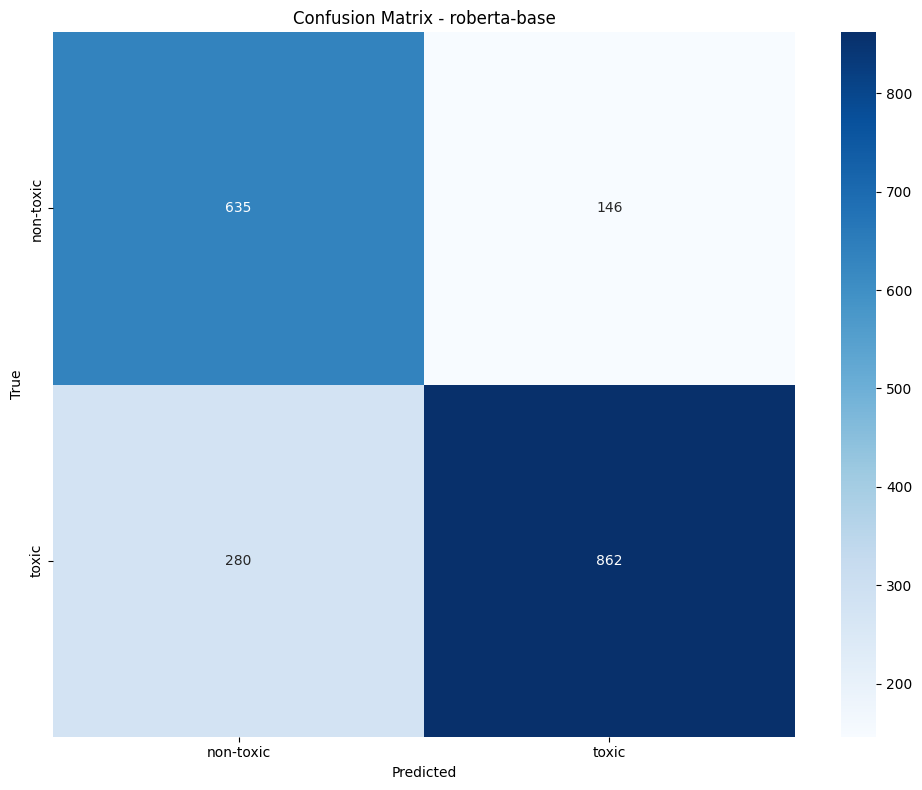

Model saved to saved_models/roberta-base_binary

Bias AUC Metrics:
GMB-SUBGROUP-AUC: 0.8290
GMB-BPSN-AUC: 0.7886
GMB-BNSP-AUC: 0.8363
GMB-COMBINED-AUC: 0.8163

BNSP AUROC by Target Group:
African: AUROC = 0.9269
Islam: AUROC = 0.8845
Jewish: AUROC = 0.9414
Homosexual: AUROC = 0.8829
Women: AUROC = 0.8441
Refugee: AUROC = 0.7467
Arab: AUROC = 0.9086
Caucasian: AUROC = 0.7220
Hispanic: AUROC = 0.9573
Asian: AUROC = 0.7865

Training xlnet-base-cased for binary classification
Train set: 15575, Validation set: 1731, Test set: 1923
Class weights: {1: 0.8423472147106544, 0: 1.2302527646129542}
Using device: cuda
No classifier dropout parameter found in config. Model: xlnet-base-cased
Please use custom classifier head if you want to implement for this model


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using custom classifier head for model: xlnet-base-cased

Epoch 1/5


Training: 100%|██████████| 974/974 [04:12<00:00,  3.85batch/s, loss=0.255]


Average training loss: 0.5467


Evaluating: 100%|██████████| 109/109 [00:09<00:00, 11.07batch/s]


Validation loss: 0.4524
Validation accuracy: 0.7915
Validation F1 score: 0.7859
Validation val_loss improved from inf to 0.4524

Epoch 2/5


Training: 100%|██████████| 974/974 [04:12<00:00,  3.86batch/s, loss=0.32]


Average training loss: 0.4409


Evaluating: 100%|██████████| 109/109 [00:09<00:00, 11.10batch/s]


Validation loss: 0.4736
Validation accuracy: 0.7886
Validation F1 score: 0.7785
Validation val_loss did not improve. Best: 0.4524, Current: 0.4736
Early stopping counter: 1/2

Epoch 3/5


Training: 100%|██████████| 974/974 [04:12<00:00,  3.86batch/s, loss=0.487]


Average training loss: 0.3589


Evaluating: 100%|██████████| 109/109 [00:09<00:00, 11.08batch/s]


Validation loss: 0.4724
Validation accuracy: 0.7845
Validation F1 score: 0.7690
Validation val_loss did not improve. Best: 0.4524, Current: 0.4724
Early stopping counter: 2/2
Early stopping triggered. Best val_loss: 0.4524 at epoch 1
Loading best model from epoch 1


Evaluating: 100%|██████████| 121/121 [00:11<00:00, 10.98batch/s]



Test Results:
Loss: 0.4661
Accuracy: 0.7665
Macro F1 Score: 0.7592


Predicting: 100%|██████████| 121/121 [00:11<00:00, 10.90batch/s]


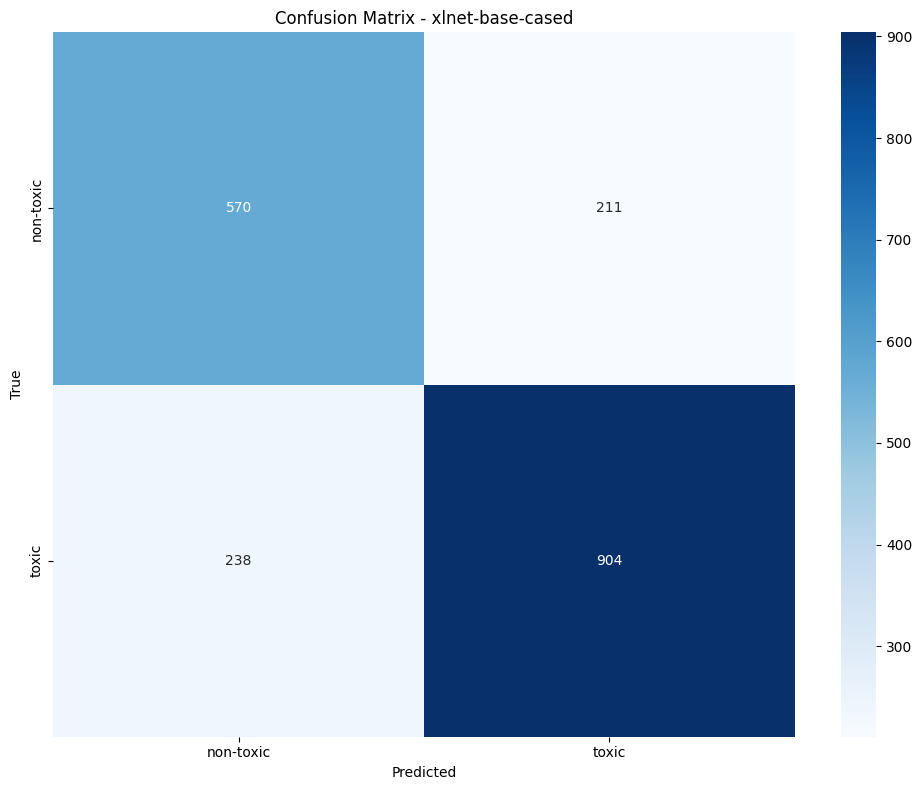

Model saved to saved_models/xlnet-base-cased_binary

Bias AUC Metrics:
GMB-SUBGROUP-AUC: 0.8043
GMB-BPSN-AUC: 0.7082
GMB-BNSP-AUC: 0.7981
GMB-COMBINED-AUC: 0.7621

BNSP AUROC by Target Group:
African: AUROC = 0.9192
Islam: AUROC = 0.8451
Jewish: AUROC = 0.9623
Homosexual: AUROC = 0.8461
Women: AUROC = 0.8369
Refugee: AUROC = 0.6764
Arab: AUROC = 0.8792
Caucasian: AUROC = 0.7075
Hispanic: AUROC = 0.9391
Asian: AUROC = 0.7219

Training microsoft/deberta-v3-base for binary classification
Train set: 15575, Validation set: 1731, Test set: 1923
Class weights: {1: 0.8423472147106544, 0: 1.2302527646129542}
Using device: cuda
No classifier dropout parameter found in config. Model: microsoft/deberta-v3-base
Please use custom classifier head if you want to implement for this model


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using custom classifier head for model: microsoft/deberta-v3-base

Epoch 1/5


Training: 100%|██████████| 974/974 [04:26<00:00,  3.66batch/s, loss=0.731]


Average training loss: 0.5228


Evaluating: 100%|██████████| 109/109 [00:08<00:00, 12.32batch/s]


Validation loss: 0.4467
Validation accuracy: 0.8059
Validation F1 score: 0.8021
Validation val_loss improved from inf to 0.4467

Epoch 2/5


Training: 100%|██████████| 974/974 [04:25<00:00,  3.66batch/s, loss=0.223]


Average training loss: 0.4215


Evaluating: 100%|██████████| 109/109 [00:08<00:00, 12.32batch/s]


Validation loss: 0.4907
Validation accuracy: 0.8013
Validation F1 score: 0.7936
Validation val_loss did not improve. Best: 0.4467, Current: 0.4907
Early stopping counter: 1/2

Epoch 3/5


Training: 100%|██████████| 974/974 [04:26<00:00,  3.66batch/s, loss=0.16]


Average training loss: 0.3526


Evaluating: 100%|██████████| 109/109 [00:08<00:00, 12.28batch/s]


Validation loss: 0.4683
Validation accuracy: 0.8117
Validation F1 score: 0.8061
Validation val_loss did not improve. Best: 0.4467, Current: 0.4683
Early stopping counter: 2/2
Early stopping triggered. Best val_loss: 0.4467 at epoch 1
Loading best model from epoch 1


Evaluating: 100%|██████████| 121/121 [00:09<00:00, 12.30batch/s]



Test Results:
Loss: 0.4500
Accuracy: 0.7769
Macro F1 Score: 0.7713


Predicting: 100%|██████████| 121/121 [00:09<00:00, 12.32batch/s]


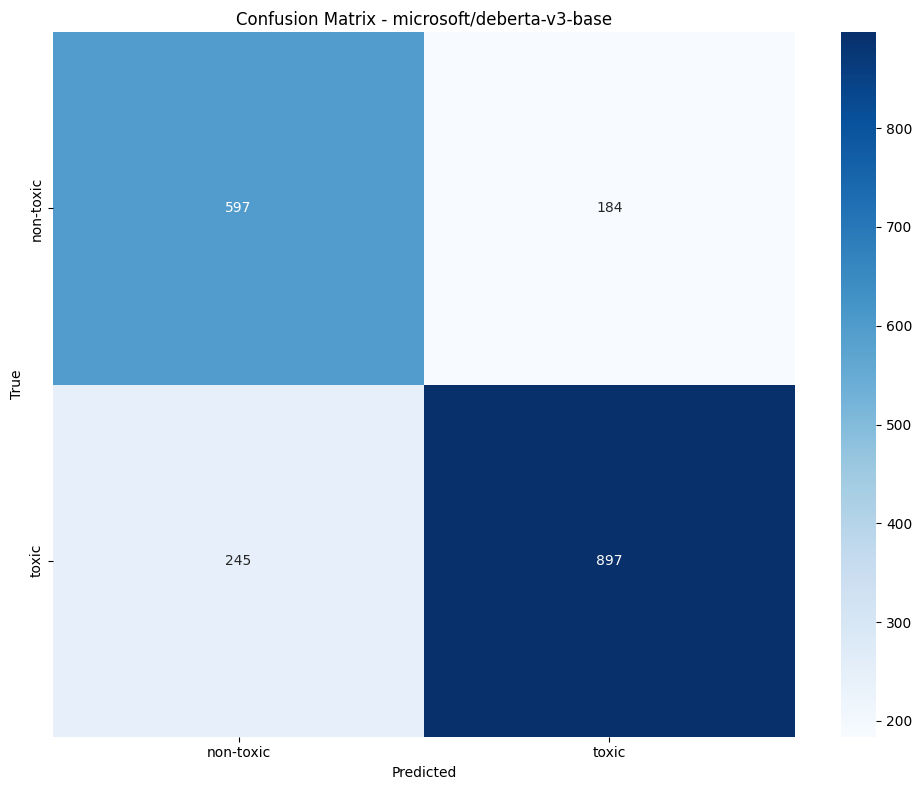

Model saved to saved_models/microsoft_deberta-v3-base_binary

Bias AUC Metrics:
GMB-SUBGROUP-AUC: 0.8225
GMB-BPSN-AUC: 0.7785
GMB-BNSP-AUC: 0.8157
GMB-COMBINED-AUC: 0.8041

BNSP AUROC by Target Group:
African: AUROC = 0.9385
Islam: AUROC = 0.8769
Jewish: AUROC = 0.9397
Homosexual: AUROC = 0.8944
Women: AUROC = 0.8501
Refugee: AUROC = 0.6909
Arab: AUROC = 0.8936
Caucasian: AUROC = 0.6965
Hispanic: AUROC = 0.9507
Asian: AUROC = 0.7773


In [7]:
models_to_compare = MODELS
print("Running model comparison...")
comparison_results = run_model_comparison(
    models_to_compare,
    data_3class,
    data_2class,
    batch_size=16,
    epochs=5,
    auto_weighted=True,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.2,
    classifier_dropout=0.3,
    custom_classifier_head=True,
    weight_decay=0.1,
    patience=2,
    min_delta=0.001,
    monitor='val_loss',
)

In [8]:
# Analyze results
print("\nAnalyzing results...")

# Create summary table
summary_table = create_summary_table(comparison_results)
print("\nModel Comparison Summary:")
pd.set_option('display.precision', 4)
print(summary_table)



Analyzing results...

Model Comparison Summary:
                     Model    Task  Accuracy  F1 Score  Precision  Recall  \
9          deberta-v3-base  3class    0.7155    0.7033     0.7024  0.7057   
5        bert-base-uncased  3class    0.6973    0.6887     0.6883  0.6892   
6  distilbert-base-uncased  3class    0.6911    0.6875     0.6882  0.6898   
8         xlnet-base-cased  3class    0.6875    0.6834     0.6852  0.6876   
7             roberta-base  3class    0.6927    0.6733     0.6773  0.6819   
0        bert-base-uncased  binary    0.7941    0.7865     0.7866  0.7863   
2             roberta-base  binary    0.7785    0.7753     0.7746  0.7839   
1  distilbert-base-uncased  binary    0.7764    0.7732     0.7725  0.7818   
4          deberta-v3-base  binary    0.7769    0.7713     0.7694  0.7749   
3         xlnet-base-cased  binary    0.7665    0.7592     0.7581  0.7607   

    AUROC  
9  0.8667  
5  0.8582  
6  0.8577  
8  0.8557  
7  0.8536  
0  0.8813  
2  0.8695  
1  0.86

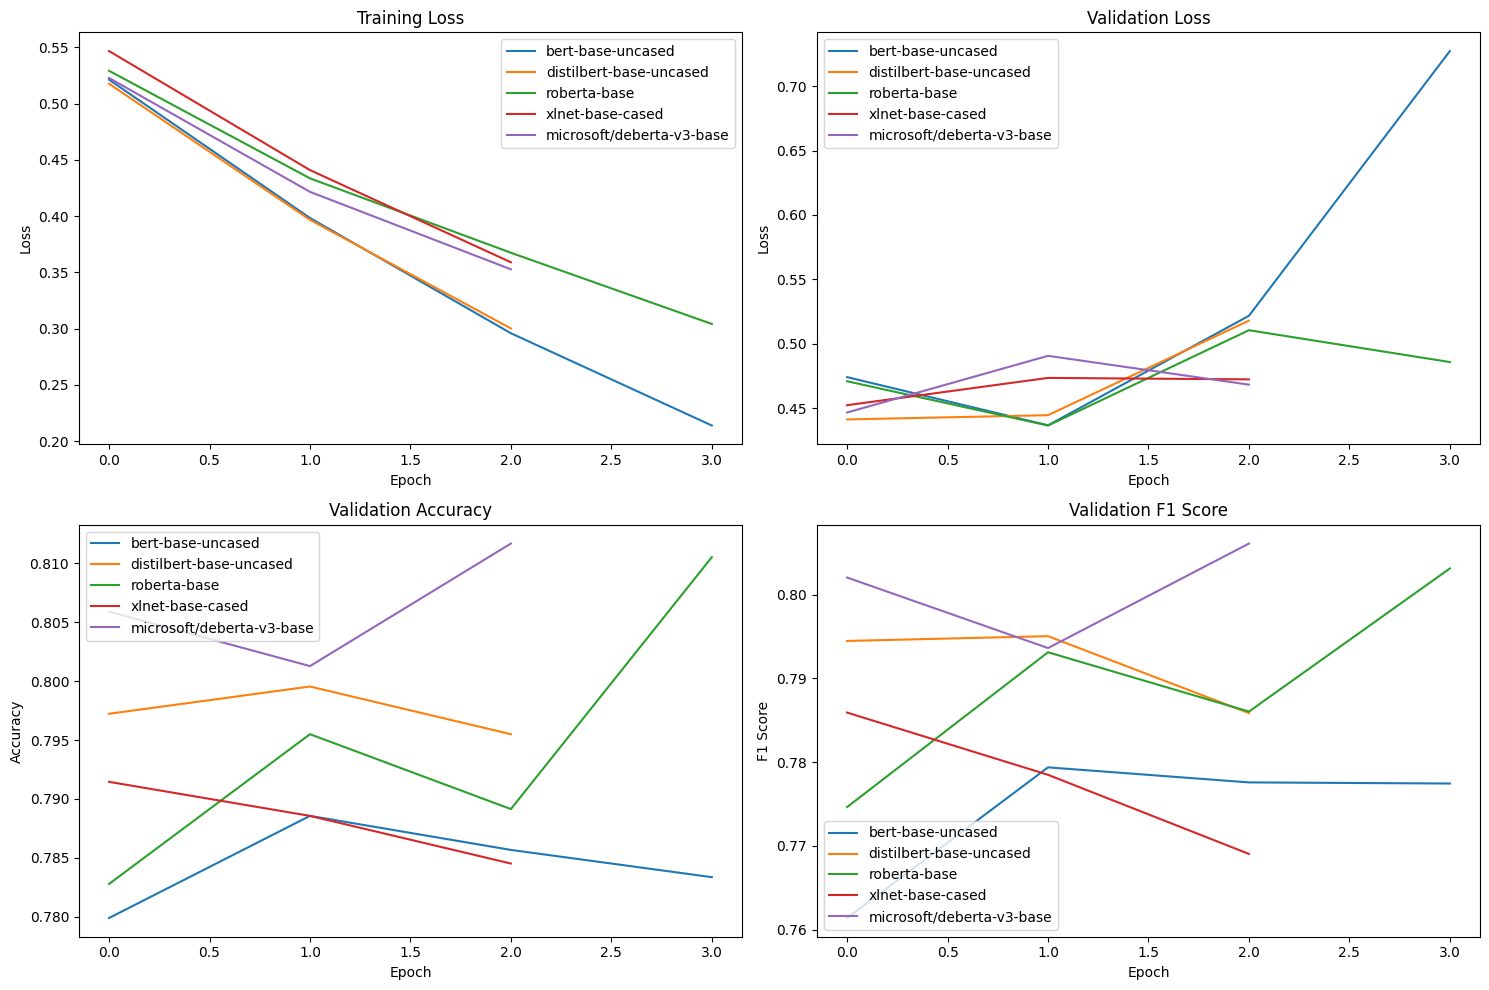

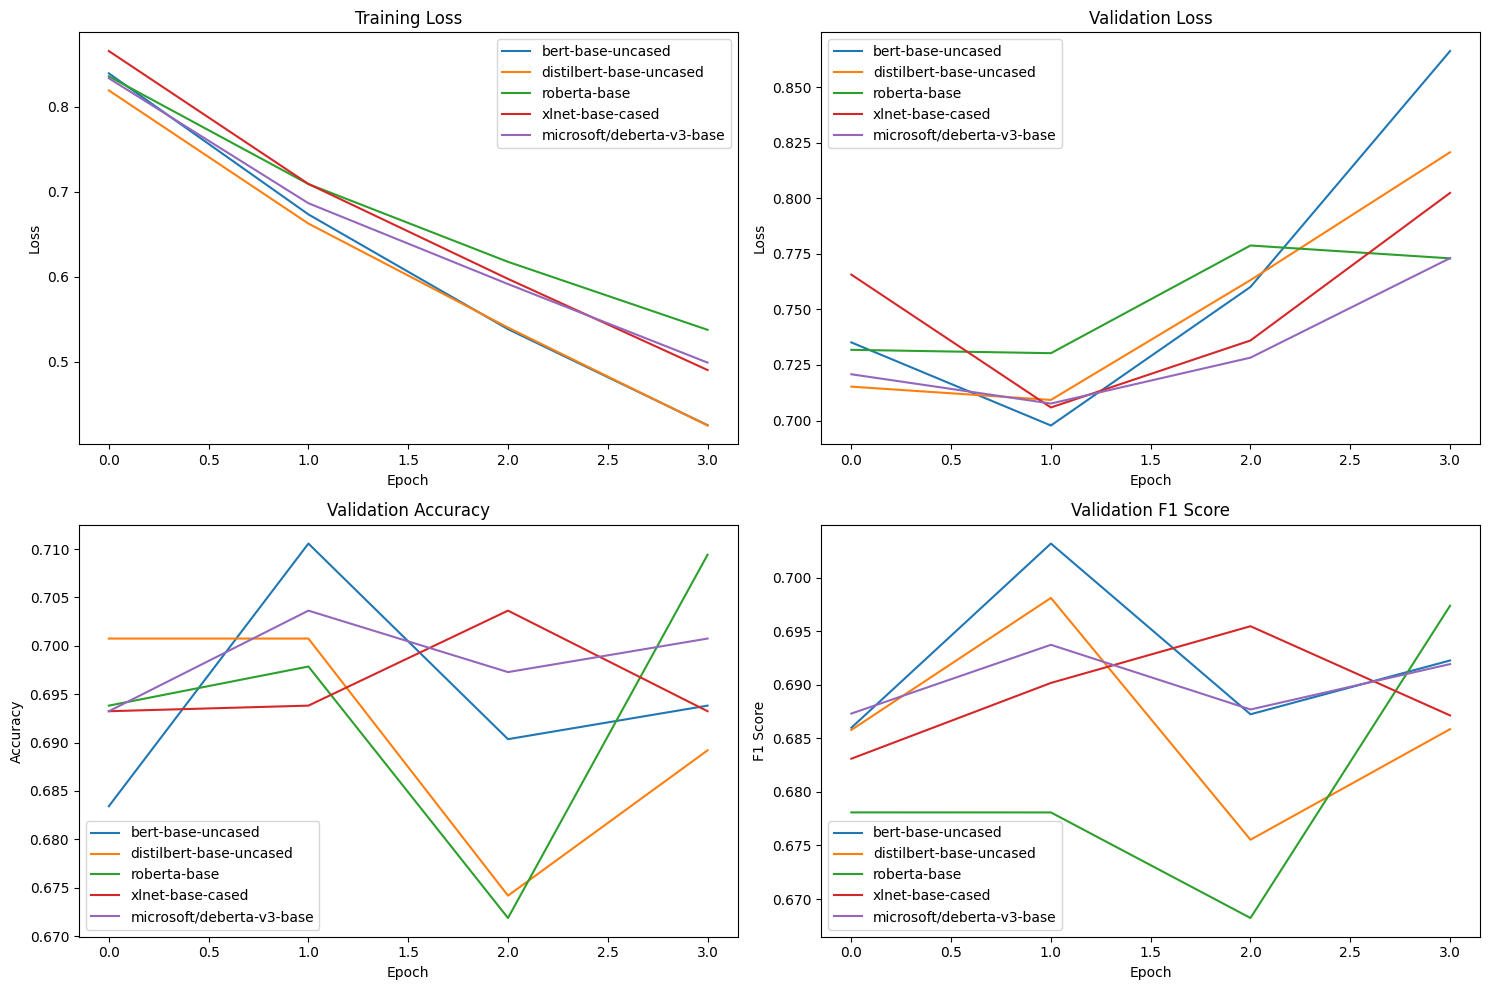

In [9]:
# Plot training history
plot_training_history(comparison_results, task_type='binary')
plot_training_history(comparison_results, task_type='3class')

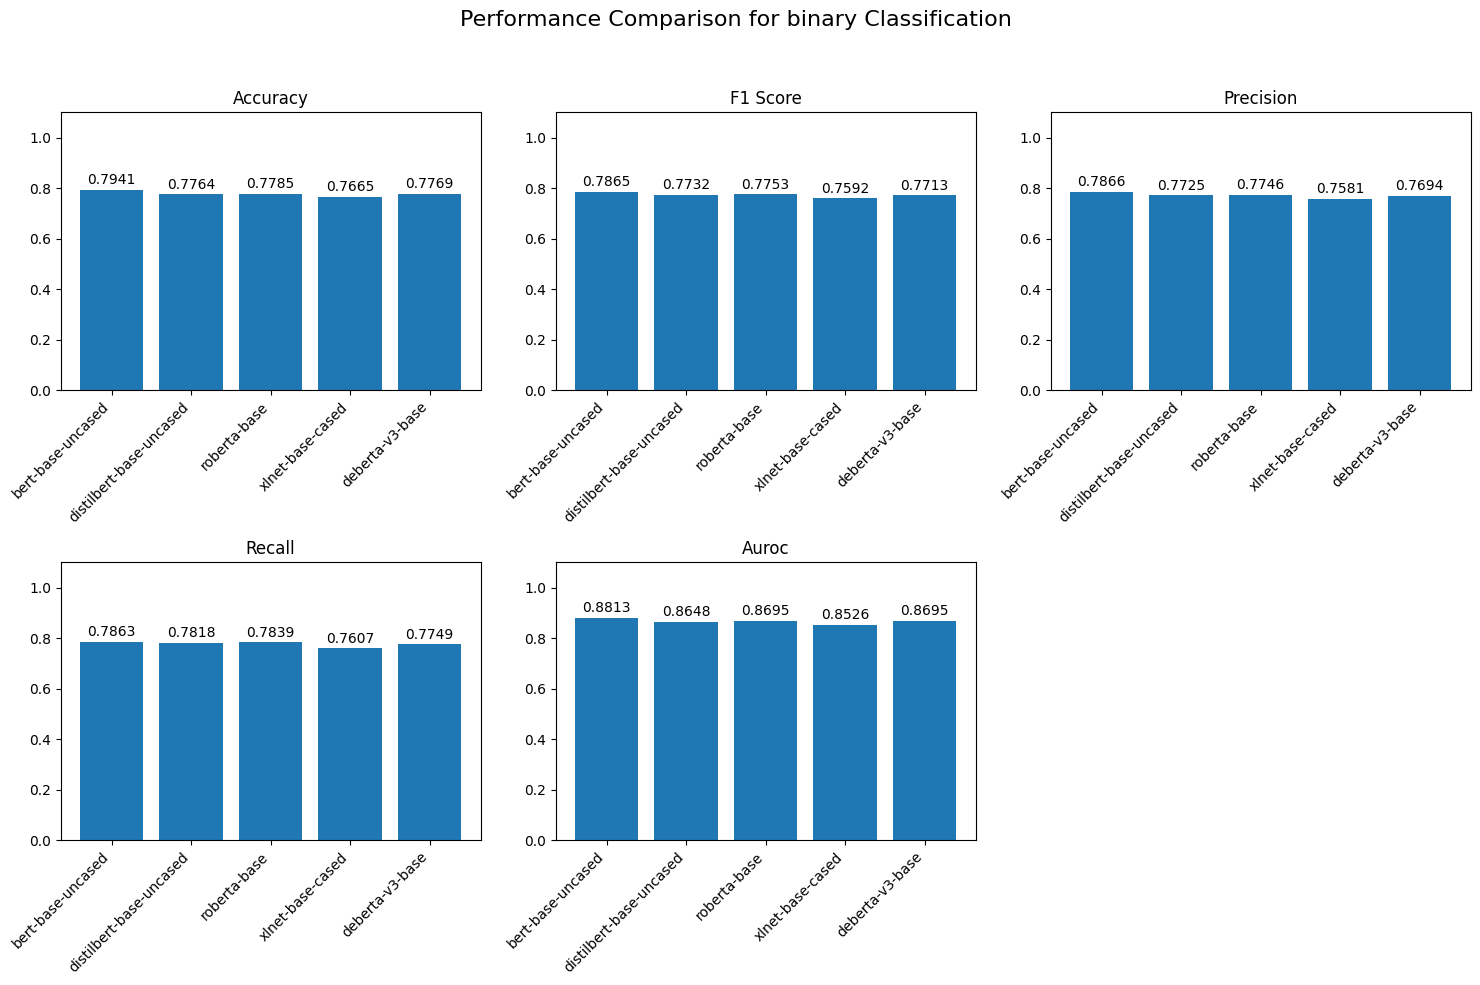

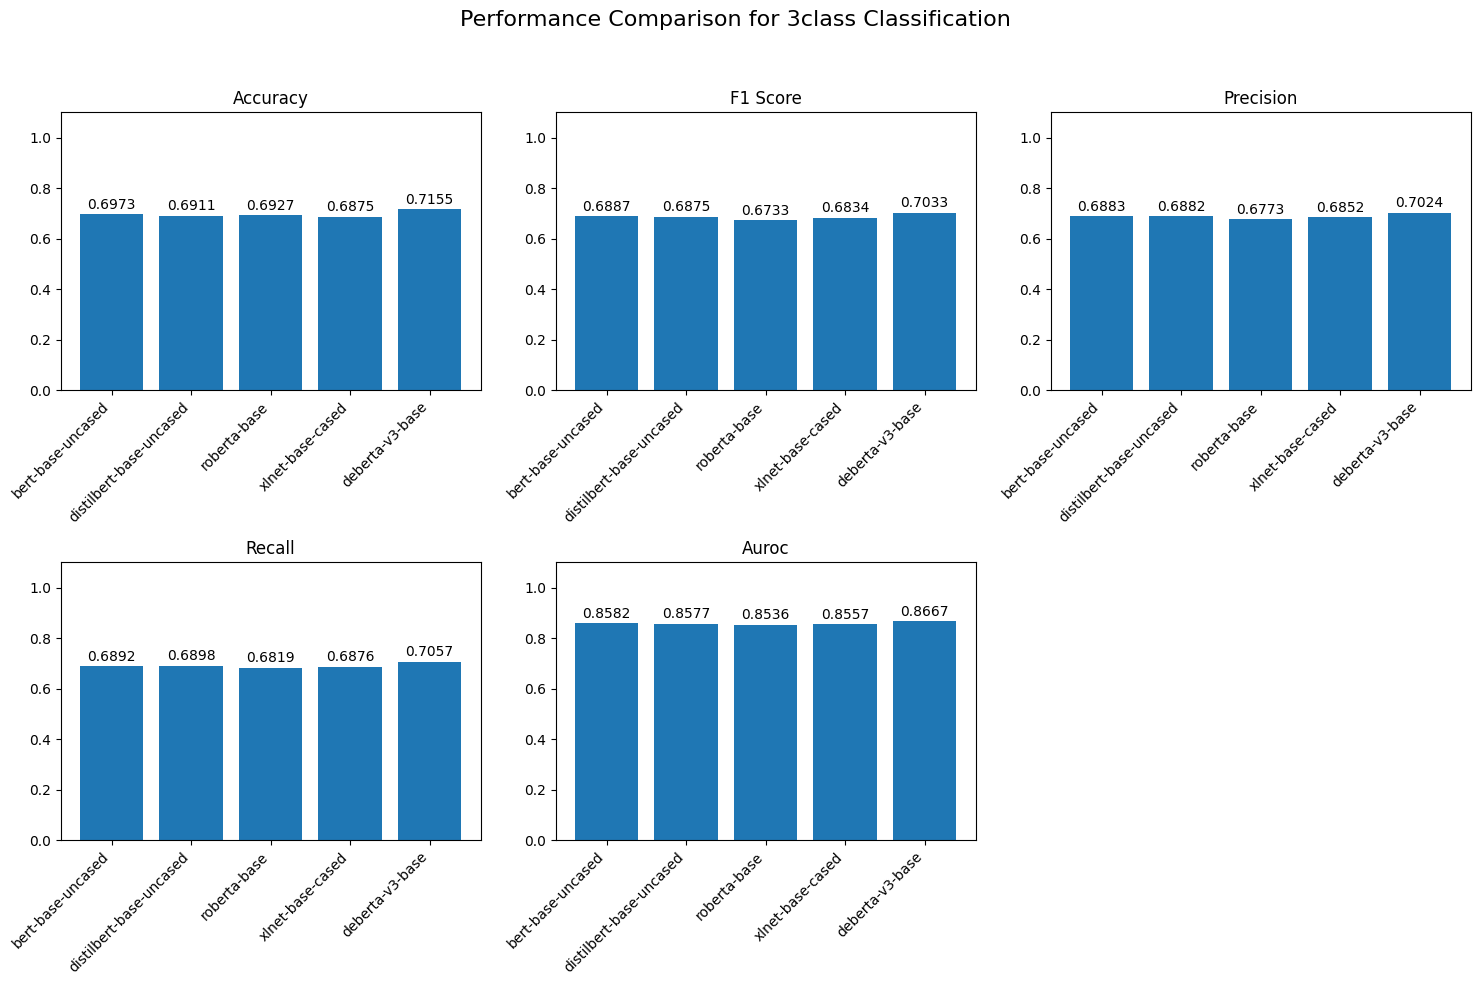

In [10]:
# Plot performance comparison
plot_performance_comparison(comparison_results)

In [11]:
# Analyze bias
analyze_bias(comparison_results, task_type='binary')
analyze_bias(comparison_results, task_type='3class')


=== Bias Analysis for binary Classification ===


Model: bert-base-uncased
Performance across target groups:
Mean accuracy: 0.8716
Standard deviation: 0.0784
Min accuracy: 0.7449
Max accuracy: 0.9672
Max-Min difference: 0.2222
Target group with worst performance: Refugee (accuracy: 0.7449)
Target group with best performance: Hispanic (accuracy: 0.9672)

GMB Metrics:
GMB-SUBGROUP-AUC: 0.8249
GMB-BPSN-AUC: 0.8034
GMB-BNSP-AUC: 0.8486
GMB-COMBINED-AUC: 0.8244

Model: distilbert-base-uncased
Performance across target groups:
Mean accuracy: 0.8532
Standard deviation: 0.0946
Min accuracy: 0.6502
Max accuracy: 0.9601
Max-Min difference: 0.3099
Target group with worst performance: Caucasian (accuracy: 0.6502)
Target group with best performance: Hispanic (accuracy: 0.9601)

GMB Metrics:
GMB-SUBGROUP-AUC: 0.8063
GMB-BPSN-AUC: 0.7469
GMB-BNSP-AUC: 0.8142
GMB-COMBINED-AUC: 0.7855

Model: roberta-base
Performance across target groups:
Mean accuracy: 0.8601
Standard deviation: 0.0785
Min accuracy: 

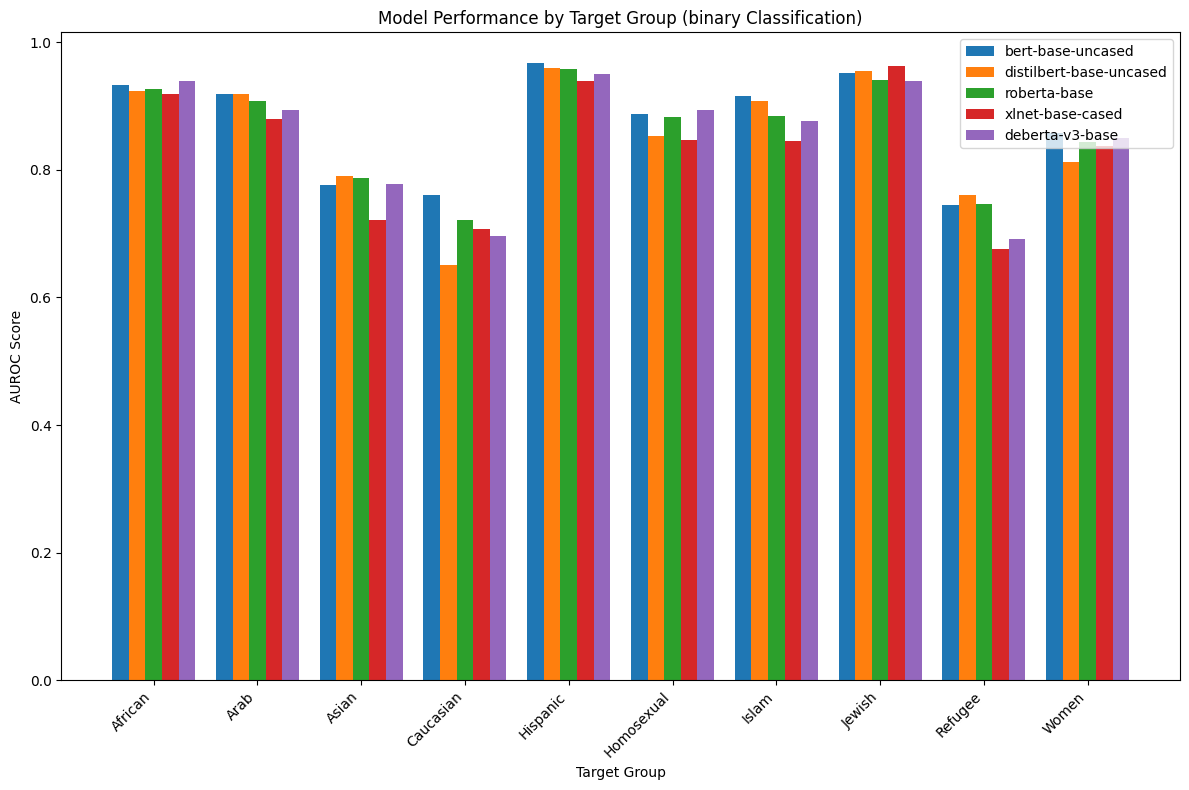

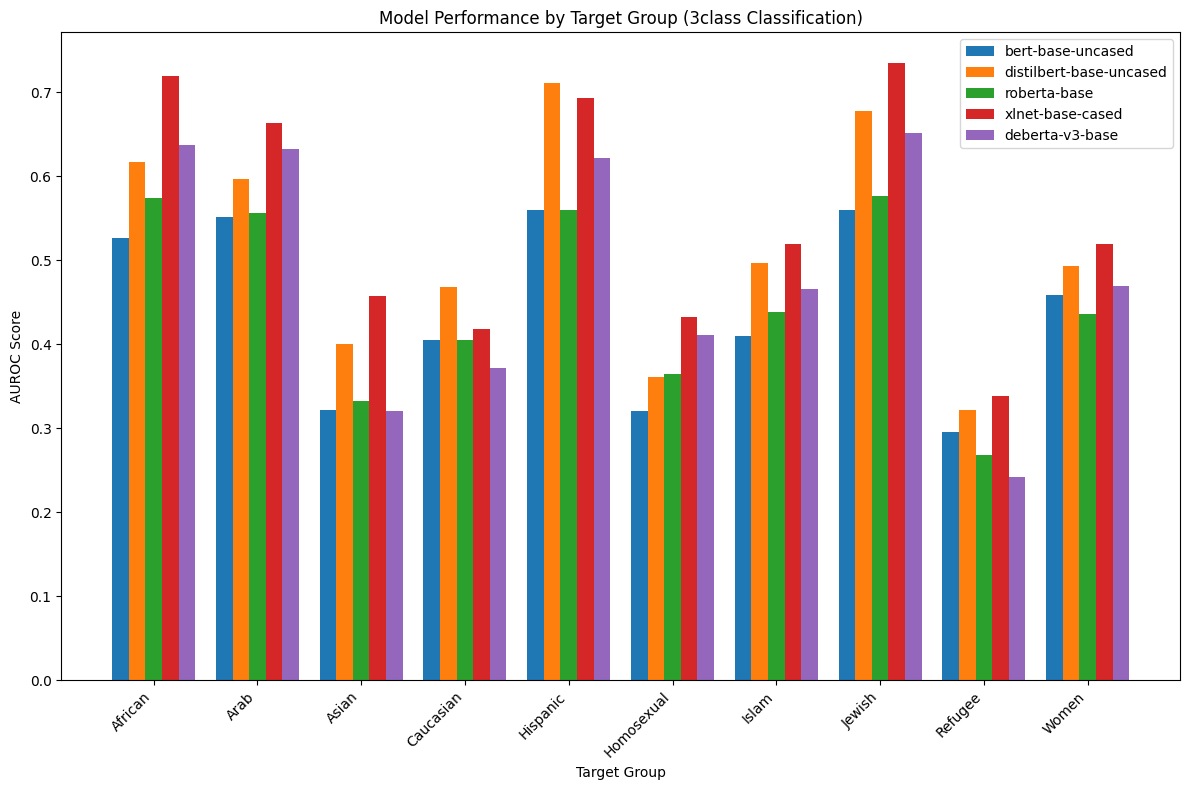

In [12]:
# Plot target group performance
plot_target_group_performance(comparison_results, task_type='binary')
plot_target_group_performance(comparison_results, task_type='3class')

In [13]:
# Analyze errors for best models
binary_best_model = summary_table[summary_table['Task'] == 'binary'].sort_values('F1 Score', ascending=False).iloc[0]['Model']
multiclass_best_model = summary_table[summary_table['Task'] == '3class'].sort_values('F1 Score', ascending=False).iloc[0]['Model']

# Get the full model name for analysis
for model_name in models_to_compare:
    if model_name.split('/')[-1] == binary_best_model:
        binary_best_model_full = model_name
    if model_name.split('/')[-1] == multiclass_best_model:
        multiclass_best_model_full = model_name

In [14]:
# Error analysis
analyze_errors(
    comparison_results, 
    data_2class, 
    task_type='binary',
    model_name=binary_best_model_full
)

analyze_errors(
    comparison_results, 
    data_3class, 
    task_type='3class',
    model_name=multiclass_best_model_full
)




=== Error Analysis for bert-base-uncased on binary Classification ===

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at saved_models/bert-base-uncased_binary were not used when initializing BertForSequenceClassification: ['classifier.0.bias', 'classifier.0.weight', 'classifier.3.bias', 'classifier.3.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassif

Model loaded from saved_models/bert-base-uncased_binary


Predicting: 100%|██████████| 121/121 [00:07<00:00, 17.01batch/s]


High-confidence errors (model was confident but wrong):

Example 1:
Text: <user> happy birthday muzzy thanks for being you 😊
True label: non-toxic
Predicted label: toxic
Confidence: 0.8022
Target groups: None

Example 2:
Text: <user> truly the ghetto
True label: non-toxic
Predicted label: toxic
Confidence: 0.7963
Target groups: None

Example 3:
Text: <user> kill yourself lol
True label: non-toxic
Predicted label: toxic
Confidence: 0.7932
Target groups: None

Example 4:
Text: disregard women and acquire currency
True label: non-toxic
Predicted label: toxic
Confidence: 0.7928
Target groups: None

Example 5:
Text: putin syria has been liberated time for refugees to return
True label: non-toxic
Predicted label: toxic
Confidence: 0.7928
Target groups: Refugee

Example 6:
Text: <user> when you been eating too many nazi cakes
True label: non-toxic
Predicted label: toxic
Confidence: 0.7914

Example 7:
Text: <user> not newark that ’ ghetto
True label: non-toxic
Predicted label: toxic
Confidence

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at saved_models/microsoft_deberta-v3-base_3class were not used when initializing DebertaV2ForSequenceClassification: ['classifier.0.bias', 'classifier.0.weight', 'classifier.3.bias', 'classifier.3.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (

Model loaded from saved_models/microsoft_deberta-v3-base_3class


Predicting: 100%|██████████| 121/121 [00:09<00:00, 12.30batch/s]


High-confidence errors (model was confident but wrong):

Example 1:
Text: <user> why tf you stalking my shit liking tweets from over a month ago do you need something or are you just like that cloutsurfin faggot hoping you will get attention from bad bitches 👀
True label: offensive
Predicted label: normal
Confidence: 0.5694
Target groups: Homosexual

Example 2:
Text: <user> stupid fkn retard
True label: offensive
Predicted label: normal
Confidence: 0.5668
Target groups: None

Example 3:
Text: <user> lol ur an idiot fool i swear all ppl do is switch around my words hating ass faggots
True label: offensive
Predicted label: normal
Confidence: 0.5661

Example 4:
Text: what does fashbrain mean you just say words without knowing what they mean stupid people are funny keep saying stupid things retarded person you are making me laugh
True label: offensive
Predicted label: normal
Confidence: 0.5650
Target groups: None

Example 5:
Text: vader calls the for hire antifa losers globalist mask weari

,post_id,text,processed_text,target_groups,final_label,predicted,true,correct,prob_hatespeech,prob_normal,prob_offensive,confidence
19140,9600971_gab,to be fair muslims turning western women into ...,to be fair muslims turning western women into ...,"[Women, Arab, Islam]",offensive,normal,offensive,False,0.3921,0.4224,0.1855,0.4224
7806,1179047042242535425_twitter,if the jury is fucked up over that white whore...,if the jury is fucked up over that white whore...,"[Disability, Women]",offensive,normal,offensive,False,0.1982,0.5363,0.2654,0.5363
11062,1116284284602474496_twitter,<user> <user> warren you look like a democrati...,warren you look like a democratic cuck who wor...,[Men],offensive,normal,offensive,False,0.1822,0.5517,0.2660,0.5517
3589,10394634_gab,yeah because the suck is making too much money...,yeah because the suck is making too much money...,[Arab],offensive,normal,offensive,False,0.3904,0.4086,0.2011,0.4086
13242,1246387576539414528_twitter,<user> paris is the ghetto i hated it there 😭,paris is the ghetto i hated it there 😭,[African],offensive,normal,offensive,False,0.2442,0.5190,0.2368,0.5190
...,...,...,...,...,...,...,...,...,...,...,...,...
15200,17116108_gab,we owe it to them to give them a real holocaus...,we owe it to them to give them a real holocaus...,[Jewish],hatespeech,normal,hatespeech,False,0.2852,0.4576,0.2572,0.4576
3830,1081534811490140160_twitter,white people are not real jews the holocuast w...,white people are not real jews the holocuast w...,"[Caucasian, Jewish]",hatespeech,normal,hatespeech,False,0.2945,0.4444,0.2612,0.4444
12969,12308531_gab,you are a fucking fat retarded faggot,you are a fucking fat retarded faggot,[Homosexual],offensive,normal,offensive,False,0.2130,0.5239,0.2631,0.5239
10993,1113292881823969285_twitter,hey guys pika pika bitch,hey guys pika pika bitch,[None],offensive,normal,offensive,False,0.2072,0.5174,0.2755,0.5174



=== Efficiency Analysis (num_classes=3) ===


Analyzing bert-base-uncased...
Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting: 100%|██████████| 61/61 [00:03<00:00, 16.95batch/s]



Analyzing distilbert-base-uncased...
Using device: cuda
No classifier dropout parameter found in config. Model: distilbert-base-uncased
Please use custom classifier head if you want to implement for this model


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting: 100%|██████████| 61/61 [00:01<00:00, 30.90batch/s]



Analyzing roberta-base...
Using device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting: 100%|██████████| 61/61 [00:03<00:00, 17.14batch/s]



Analyzing xlnet-base-cased...
Using device: cuda
No classifier dropout parameter found in config. Model: xlnet-base-cased
Please use custom classifier head if you want to implement for this model


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting: 100%|██████████| 61/61 [00:05<00:00, 11.14batch/s]



Analyzing microsoft/deberta-v3-base...
Using device: cuda
No classifier dropout parameter found in config. Model: microsoft/deberta-v3-base
Please use custom classifier head if you want to implement for this model


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting: 100%|██████████| 61/61 [00:04<00:00, 12.49batch/s]



Efficiency Results:
                     Model  Parameters (M)  Inference Time (s)  Samples/Second
1  distilbert-base-uncased         66.9558              1.9779        486.3665
2             roberta-base        124.6479              3.5640        269.9217
0        bert-base-uncased        109.4845              3.6023        267.0512
4          deberta-v3-base        184.4245              4.8897        196.7389
3         xlnet-base-cased        117.3112              5.4796        175.5591


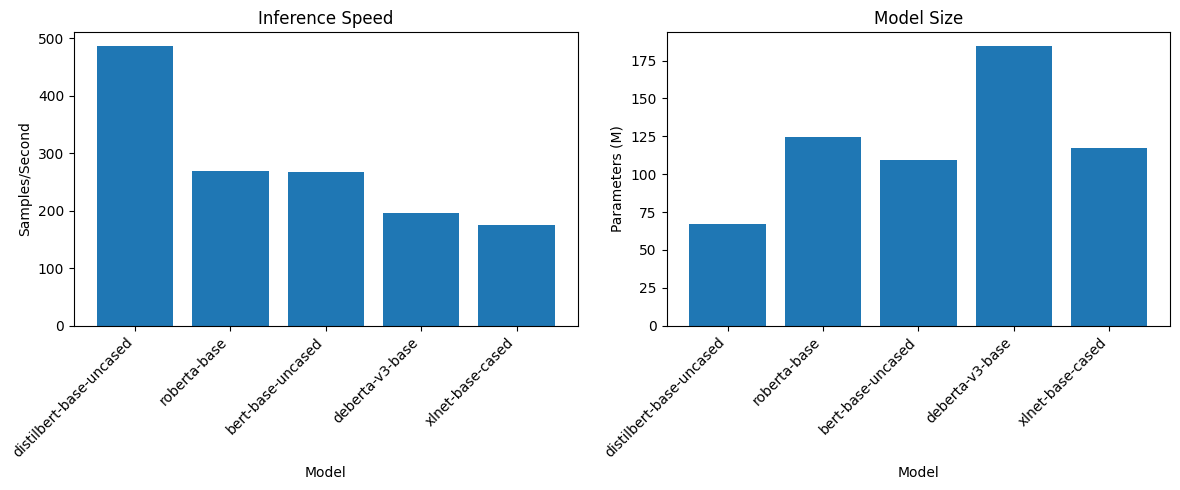

In [15]:
# Efficiency analysis
efficiency_results = analyze_efficiency(
    models_to_compare,
    data_3class,
    num_classes=3,
    batch_size=BATCH_SIZE
)

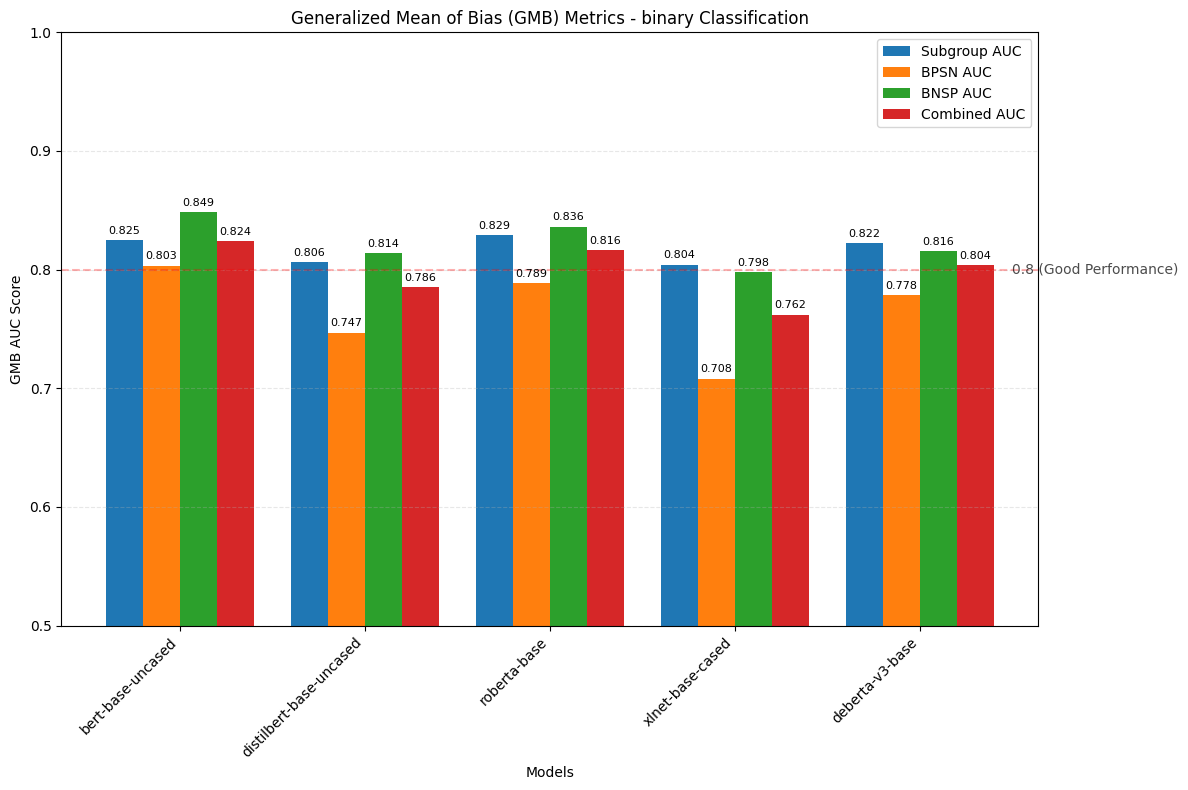

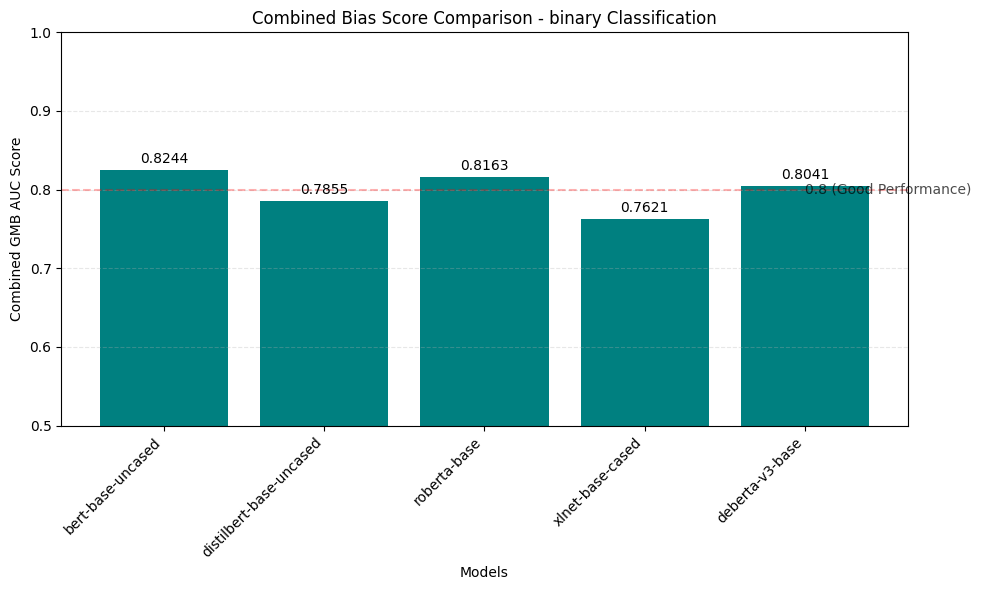

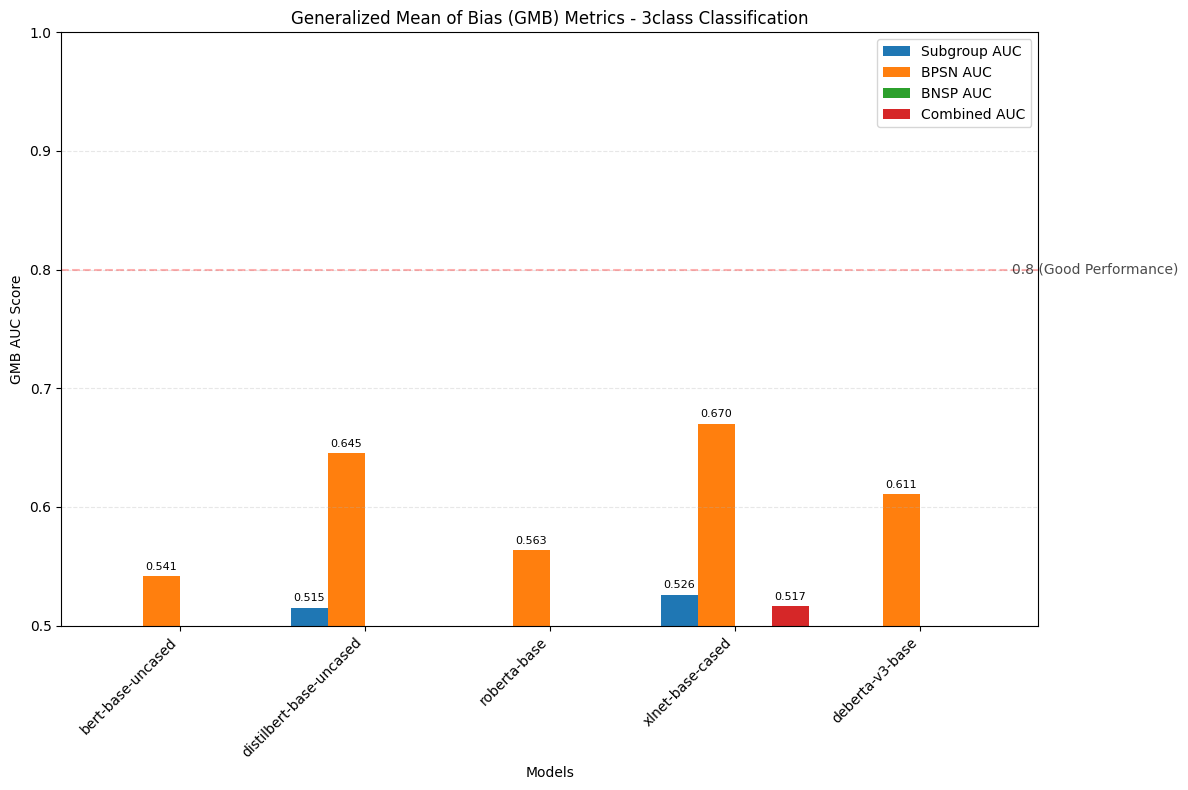

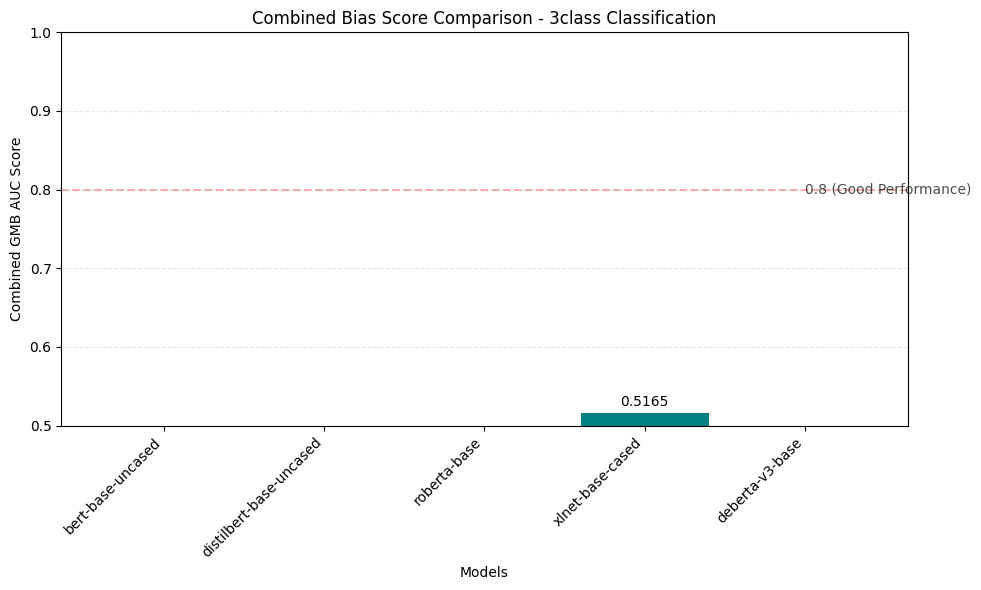

In [16]:
# Plot GMB metrics
plot_gmb_metrics(comparison_results, task_type='binary')
plot_gmb_metrics(comparison_results, task_type='3class')

In [17]:
# Generate conclusions
generate_conclusions(summary_table, efficiency_results)


=== FINAL CONCLUSIONS ===

Best model for binary classification:
bert-base-uncased: F1 Score = 0.7865, Accuracy = 0.7941

Best model for 3-class classification:
deberta-v3-base: F1 Score = 0.7033, Accuracy = 0.7155

Most efficient model: distilbert-base-uncased (486.37 samples/second)

Best balance of performance and efficiency:
distilbert-base-uncased on binary task
F1 Score: 0.7732
Inference Speed: 486.37 samples/second
Model Size: 66.96 million parameters

Recommendations:
1. For production environments where speed is critical, consider using a distilled model
2. For applications requiring high accuracy, especially in detecting hate speech, use the best performing model
3. For a balance of performance and efficiency, consider the model with the best balanced score
4. Further research should focus on reducing bias across target groups, as performance varies significantly


In [18]:
# Save results
save_results(comparison_results, summary_table, efficiency_results)

print("\n=== Project completed successfully ===")

All results saved to the 'results' directory

=== Project completed successfully ===
